 <a id='задачи'></a>

<b>Задание</b>

1. [Познакомьтесь с данными.](#1-знакомство)
2. [Добавьте информацию из датасета region.csv](#2-добавить-инфу)
- [2.1 Работа с данными до объединения файлов](#21-работа-до-добавления)
- [2.2 Добавление информации](#22-добавление-инфы)
- [2.3 Вывод по пункту 2](#23-вывод-2)
3. [Исследуйте рынок недвижимости в РФ за представленный период. Величина исследования - цена за м2. Обработайте аномалии.](#3-исследование-рынка)
- [3.1 Поиск дубликатов и проверка типов данных](#31-дубликаты-типы)
- [3.2 Аномалии столбца price](#32-аномалии-цена)
- [3.3 Аномалии столбцов level & levels](#33-аномалии-этаж)
- [3.4 Аномалии столбцов rooms -> area -> kitchen_area](#34-аномалии-площадь)
- [3.5 Аномалии столбца building_type](#35-аномалии-тип)
- [3.6 Вывод по пункту 3](#36-вывод-3)
4. [Восстановите пропуски в столбце kitchen_area.](#4-пропуски)
- [4.1 Применение RandomForest](#41-лес)
- [4.2 Вывод по пункту 4](#42-вывод-4)
5. [Когда выгодно покупать/продавать объект недвижимости? ](#5-выгода)
- [5.1 Анализ рынка недвижимости](#51-выгода-продажа-покупка)
- [5.2 Вывод по пункту 5](#52-вывод-5)
6. [Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.](#6-признаки)
- [6.1 Зависимость стоимости объекта от категориальных признаков признаков](#61-категории)
- [6.2 Зависимость стоимости объекта от числовых признаков](#62-числа)
- [6.3 Поиск скрытых закономерностей](#63-скрытые-закономерности)
- [6.4 Вывод по пункту 6](#64-вывод-6)
7. [Выдвинете и проверьте собственную гипотезу статистическими методами.](#7-своя-гипотеза)
- [7.1 Бутстрапирование](#71-бутстрэп)
- [7.2 Вывод по пункту 7](#72-вывод-7)
8. [Создайте модель прогноза цены объекта недвижимости.](#8-модель-прогноза)
- [8.1 Модель прогноза](#81-модель)
- [8.2 Вывод по пункту 8](#82-вывод-8)
9. [Общий вывод](#9-общий-вывод)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import stats as st
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import normaltest, shapiro, skew, kurtosis
from scipy.stats import kruskal
import dask.dataframe as dd
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import mannwhitneyu 

<a id='1-знакомство'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">1. Познакомьтесь с данными. </h1>
</div>

[Вернуться к содержанию](#задачи)

Загружаем наши данные, чтобы ознакомиться с ними и проработать в дальнейшем

In [2]:
df = pd.read_csv('realty_18_21.csv')

In [3]:
temporary_df = pd.read_csv('region.csv')

In [4]:
df.sample(5)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
669285,3290000,2018-12-05,5952,1,3,9,3,65.00,9.00,1
1980124,4999000,2019-06-12,2661,2,7,21,1,32.70,NaN,1
4236386,2800000,2020-08-04,2843,1,4,5,2,42.70,6.00,1
4084971,6400000,2020-07-14,2661,4,5,10,2,55.00,9.00,1
4653495,6646640,2020-11-01,7896,3,9,9,1,73.04,30.18,11


In [5]:
df.shape  #проверяем полность ли загрузился файл, т.к. он большой и мог прогрузиться не полностью. Все в порядке

(5477006, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 417.9+ MB


**Основной дата фрейм содержит более 5 млн строк и 9 столбцов. Названия столбоцов понятны и читаемы, заменять не будем. Сразу заметим, что столбец с датой имеет не тот формат. Исправим это позже при работе с аномалиями. У остальных столбцов тип данных в порядке**

In [7]:
temporary_df.sample(5)

,code,reg_name
13,5282,Челябинская область
55,2528,Саратовская область
31,2072,Воронежская область
79,69,Еврейская автономная область
34,11171,Республика Саха (Якутия)


In [8]:
temporary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      83 non-null     object
 1   reg_name  83 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


**Во втором дата фрейме столбца лишь два и 83 строки. С помощью столбца с кодом мы объединим файлы вместе. Но, заметим, что столбец с кодом имеет формат object, позже заменим на int и сопаставим его со столбцом region из df. Нулевых значений нет**

<a id='2-добавить-инфу'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">2. Добавьте информацию из датасета region.csv </h1>
</div>

[Вернуться к содержанию](#задачи)

<a id='21-работа-до-добавления'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 2.1 Работа с данными до объединения файлов
</div>

[Вернуться к содержанию](#задачи)

In [9]:
#temporary_df['code'] = temporary_df['code'].astype(int)

ValueError: invalid literal for int() with base 10: '7873, 6937'

Первая аномалия найдена еще до обработки данных. При выполнении кода, была обноружена данная ошибка. Посмотрим в какой строке она встречается и как это можно изменить

In [10]:
temporary_df.loc[temporary_df['code'] == '7873, 6937']

,code,reg_name
36,"7873, 6937",Республика Крым


**Строчка найдена, теперь посмотрим какой код соотвествует Республике Крым из этих двух и соответствуют ли они вообще**

In [11]:
temporary_df.loc[temporary_df['code'].isin(['7873', '6937'])]  
#По коду 7873, 6937 строки не найдены, посмотрим какому коду соответсует Республика Крым

,code,reg_name


In [12]:
temporary_df.loc[temporary_df['reg_name'] == 'Республика Крым']
#Республика Крым встречается только один раз с "ошибочной строкой", посмотрим есть ли в df в столбце region данные коды

,code,reg_name
36,"7873, 6937",Республика Крым


In [13]:
df.loc[df['region'].isin([7873,6937])]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
1558,2150000,2018-09-08,7873,4,3,4,1,46.0,13.0,1
326778,1250000,2018-10-22,6937,1,4,5,1,39.0,8.0,1
419171,2000000,2018-11-05,6937,4,1,2,3,80.0,15.0,1
425671,911240,2018-11-06,7873,1,2,3,1,24.0,NaN,11
429326,3000000,2018-11-06,7873,4,2,3,1,60.0,5.0,1
...,...,...,...,...,...,...,...,...,...,...
5475529,9500000,2021-05-01,6937,2,6,9,3,76.0,10.0,1
5476096,4500000,2021-05-01,6937,1,5,5,3,54.0,5.0,1
5476107,7200000,2021-05-01,6937,4,9,9,3,70.0,40.0,1
5476899,4400000,2021-05-01,6937,4,2,5,3,64.0,6.2,1


**Коды 7873 и 6937 встречаются 6941 раз, что не мало, хоть мы и имеем свыше 5 млн строк. Допускаем, что Республика Крым может соотвествовать двум значениям. Тогда можем заменить один код на другой, чтобы не путаться в последствии. На достоверность данных это не повлияет, а значит мы никак их не испортим. Посмотрим сколько строк получим по каждому коду поотдельности**

In [14]:
df.loc[df['region'] == 7873]['region'].count()

2241

In [15]:
df.loc[df['region'] == 6937]['region'].count()

4700

**Код 6937 встречается чаще, заменим 7873 на него**

In [16]:
temporary_df['code'] = temporary_df['code'].replace('7873, 6937','6937')

In [17]:
df['region'] = df['region'].replace(7873,6937)

In [18]:
#теперь можем заменить тип данных у столбца code
temporary_df['code'] = temporary_df['code'].astype(int)

In [19]:
#проверим, что все сработало
temporary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      83 non-null     int32 
 1   reg_name  83 non-null     object
dtypes: int32(1), object(1)
memory usage: 1.1+ KB


<a id='22-добавление-инфы'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 2.2 Добавление информации
</div>

[Вернуться к содержанию](#задачи)

In [20]:
#посмотрим количество уникальных значений, чтобы убедиться, что объединение пройдет успешно
df['region'].nunique()

83

In [21]:
temporary_df['code'].nunique()
#все в порядке, можно добавлять

83

In [22]:
df = df.merge(temporary_df, left_on='region', right_on='code', how='left')
df.sample(5)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,code,reg_name
931139,5681763,2019-01-15,3,2,2,12,1,38.3,16.0,11,3,Москва
3776530,1799000,2020-05-24,7793,1,3,5,2,52.0,8.1,1,7793,Псковская область
2610259,2500000,2019-09-21,3106,3,1,4,3,77.0,10.0,1,3106,Самарская область
2025582,16246620,2019-06-19,3,2,12,20,3,68.9,NaN,11,3,Москва
1191575,900000,2019-02-20,6171,1,3,5,2,47.0,6.0,1,6171,Свердловская область


In [23]:
#проверяем, что столбцы region и code динаковые и один из них можно удалить
(df['region'] == df['code']).all()

True

In [24]:
df = df.drop(columns = 'code')  #удаляем любой из столбцов, я выбрала code
df.sample(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name
341347,2310000,2018-10-24,3991,2,3,16,1,35.0,9.0,1,Тюменская область


<a id='23-вывод-2'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 2.3 Вывод по пункту 2
</div>

[Вернуться к содержанию](#задачи)

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

**Перед добавлением названий регионов в основной датафрейм пришлось поработать с данными. Была исправлена аномалия с кодом у Республики Крым, путем выбора одного из двух кодов и их замены. После был поменен тип данных с object на int по столбцу code. После исправления всех ошибок, данные были успешно добавлены, а лишний столбец удален. Теперь, с названием регионов, нам будет проще ориентироваться в данных и анализировать их**
</div>

3. Восстановите пропуски в столбце kitchen_area


In [25]:
df.isna().sum()

price                 0
date                  0
region                0
building_type         0
level                 0
levels                0
rooms                 0
area                  0
kitchen_area     253711
object_type           0
reg_name              0
dtype: int64

**Столбец с площадью кухни единственный имеет пропуски в количестве 253711. Площадб кухни зависит от площади квартиры и количества комнат(пока спорно), поэтому заполнить все пропуски медианой не получится. Было принято решение ипользовать модель множественной регрессии. Но данные пока не обработаны от аномалий, а значит мы можем получить некорректное заполнение пропусков. Сначала проанализируем данные, исправим их при необходимости, а после займемся пропусками**

<a id='3-исследование-рынка'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">3. Исследуйте рынок недвижимости в РФ за представленный период. Величина исследования - цена за м2. Обработайте аномалии </h1>
</div>

[Вернуться к содержанию](#задачи)

**Значения в нашем файле должны передавать реальную картинку на рынке недвижимости. Для проверки правдоподобности данных будет использовать сервис Циан, для примерного понимания происходящей ситуации на рынке**

<a id='31-дубликаты-типы'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
    
## 3.1 Поиск дубликатов + проверка типов данных
</div>

[Вернуться к содержанию](#задачи)

In [26]:
df.duplicated().sum()  #проверяем наличие явных дубликатов

235655

In [27]:
df = df.drop_duplicates() #удаляем явные дубликаты

**Удаляем все явные дубликаты, т.к. вероятность совпадения всех характеристик объявления очень маловероятна. А вот попадание данных об одних и тех же квартирах очень реалистично. Например, если данные в файл собирали с разных сайтов, многие продавцы дублируют свои объявления на все возможные платформы**

**Т.к. данные у нас за несколько лет, также можно предположить, что одни и те же квартиры выкладывались на протяжении этого времени несколько раз, в результате чего в датафрейм попали по несколько раз**

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5241351 entries, 0 to 5477005
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
 10  reg_name       object 
dtypes: float64(2), int64(7), object(2)
memory usage: 479.9+ MB


**Все столбцы, кроме даты, имеют правильный тип данных. Еще поменяем столбцу object_type тип данных на bool, где первичный рынок - 0, вторичный - 1**

In [29]:
df['date'] = pd.to_datetime(df['date'])

In [30]:
df['object_type'] = df['object_type'].replace({11: True, 1: False})
df['object_type'] = df['object_type'].astype(bool)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7412\3724919784.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['object_type'] = df['object_type'].replace({11: True, 1: False})


<a id='32-аномалии-цена'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 3.2 Аномалии столбца price
</div>

[Вернуться к содержанию](#задачи)

Аномалия может заключаться в слишком высоких ценах и отрицательных. Для начала посмотрим наличие отрицательных цен

In [31]:
negative_count = (df['price'] < 0).sum()

print(f'Количество отрицательных значений в столбце "price": {negative_count}')

Количество отрицательных значений в столбце "price": 311


Итак, есть два предположения: 
- данные с отрицательными значениями нужно удалить, т.к. они не реальны (слишком малы или высоки)
- перед ценой - появился случайно, нужно заменить их по модулю

In [32]:
negative_price = df[df['price'] < 0]  #смотрим строки, содержащие отрицательную цену
negative_price

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name
43821,-1633967296,2018-09-14,5520,1,13,22,1,38.92,NaN,True,Пермский край
43822,-1633967296,2018-09-14,5520,1,14,22,1,38.92,17.26,True,Пермский край
199895,-429242296,2018-10-04,9654,2,5,25,2,57.27,9.31,True,Новосибирская область
208483,-1744967296,2018-10-06,9654,3,4,5,2,45.00,6.00,False,Новосибирская область
234799,-2053850296,2018-10-10,9654,1,2,10,3,87.39,12.92,True,Новосибирская область
...,...,...,...,...,...,...,...,...,...,...,...
5382188,-2041757296,2021-04-23,2604,3,2,4,1,41.08,9.31,True,Ярославская область
5382595,-1794967296,2021-04-23,81,1,4,5,2,56.00,9.00,False,Московская область
5398253,-1494967296,2021-04-26,2843,3,3,3,1,45.00,17.00,True,Краснодарский край
5419426,-2094967296,2021-04-27,3991,3,14,19,1,30.00,8.00,False,Тюменская область


**Как можно заметить, большинство отрицательных значений слишком большие, даже если их брать по модулю. Квартиры в любом случае столько стоить не могут, тем более вне Москвы. Удалим отрицательные значения, их всего 311, поэтому нам это не снизит точность исследования**

In [33]:
df = df[df['price'] > 0] #меняем знак отрицательным значениям

In [35]:
df.sample(10)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name
5184445,4750000,2021-03-19,9654,1,9,12,3,69.50,15.00,False,Новосибирская область
883195,4400000,2019-01-04,2843,2,3,5,2,62.00,7.00,False,Краснодарский край
24869,7200000,2018-09-11,3,1,3,5,2,46.30,6.00,False,Москва
3663362,7840000,2020-04-27,2661,2,7,18,2,59.20,12.00,True,Санкт-Петербург
2911157,2420000,2019-11-20,9654,3,7,15,1,25.90,5.00,True,Новосибирская область
4924482,2014000,2021-01-08,2922,2,7,16,-1,26.50,6.60,True,Республика Татарстан
815867,4000000,2018-12-25,81,1,4,16,2,60.70,14.00,False,Московская область
3917775,26042500,2020-06-18,3,2,11,24,3,94.70,18.40,True,Москва
2339630,2600000,2019-08-04,9654,1,3,18,-1,73.23,25.35,True,Новосибирская область
5042771,3500000,2021-02-17,1010,2,5,17,2,46.00,8.40,False,Удмуртская Республика


In [36]:
df['price'].describe()

count    5.241017e+06
mean     4.606550e+06
std      1.482006e+07
min      1.000000e+00
25%      2.000000e+06
50%      3.050000e+06
75%      4.940000e+06
max      2.147484e+09
Name: price, dtype: float64

**Столбец price в основном содержит очень высокие цены, где средняя цена составляет 4,6 млн рублей. Делаем вывод, что в столбце записаны цены за всю квартиру. Но наша величина исследования - цена за м2. добавим новый столбец**

In [37]:
df['price_m2'] = df['price'] / df['area']  
#делим стоимость квартиры на ее площадь

In [38]:
df['price_m2'] = df['price_m2'].astype(int)  #удаляем дробную часть цены

**Сначала удалим максимально далекие выбросы. На сайте Циан самая максимальная цена за м2 составляет 10 млн рублей. Это верхняя граница для Москвы**

In [39]:
df.loc[df['price_m2'] > 10000000] 

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2
900,1451892000,2018-09-08,9654,1,9,10,3,59.02,45.50,True,Новосибирская область,24600000
908,1003425000,2018-09-08,9654,1,9,10,1,39.35,4.39,True,Новосибирская область,25500000
5215,1003425000,2018-09-09,9654,1,9,10,1,39.35,4.39,True,Новосибирская область,25500000
5224,1451892000,2018-09-09,9654,1,9,10,3,59.02,45.50,True,Новосибирская область,24600000
9890,1451892000,2018-09-10,9654,1,9,10,3,59.02,45.50,True,Новосибирская область,24600000
...,...,...,...,...,...,...,...,...,...,...,...,...
5290349,225000000,2021-04-06,3,4,7,7,-2,9.00,25.00,False,Москва,25000000
5374584,199000000,2021-04-21,2661,3,2,3,-2,9.00,25.00,False,Санкт-Петербург,22111111
5389809,1600000000,2021-04-24,2843,3,3,3,2,53.00,13.00,False,Краснодарский край,30188679
5392144,431763475,2021-04-24,2661,3,13,27,1,32.00,8.60,False,Санкт-Петербург,13492608


In [40]:
#таких значений немного, удалим и посмотрим как будет выглядить распределение наших цен
df = df[df['price_m2'] <= 10000000]

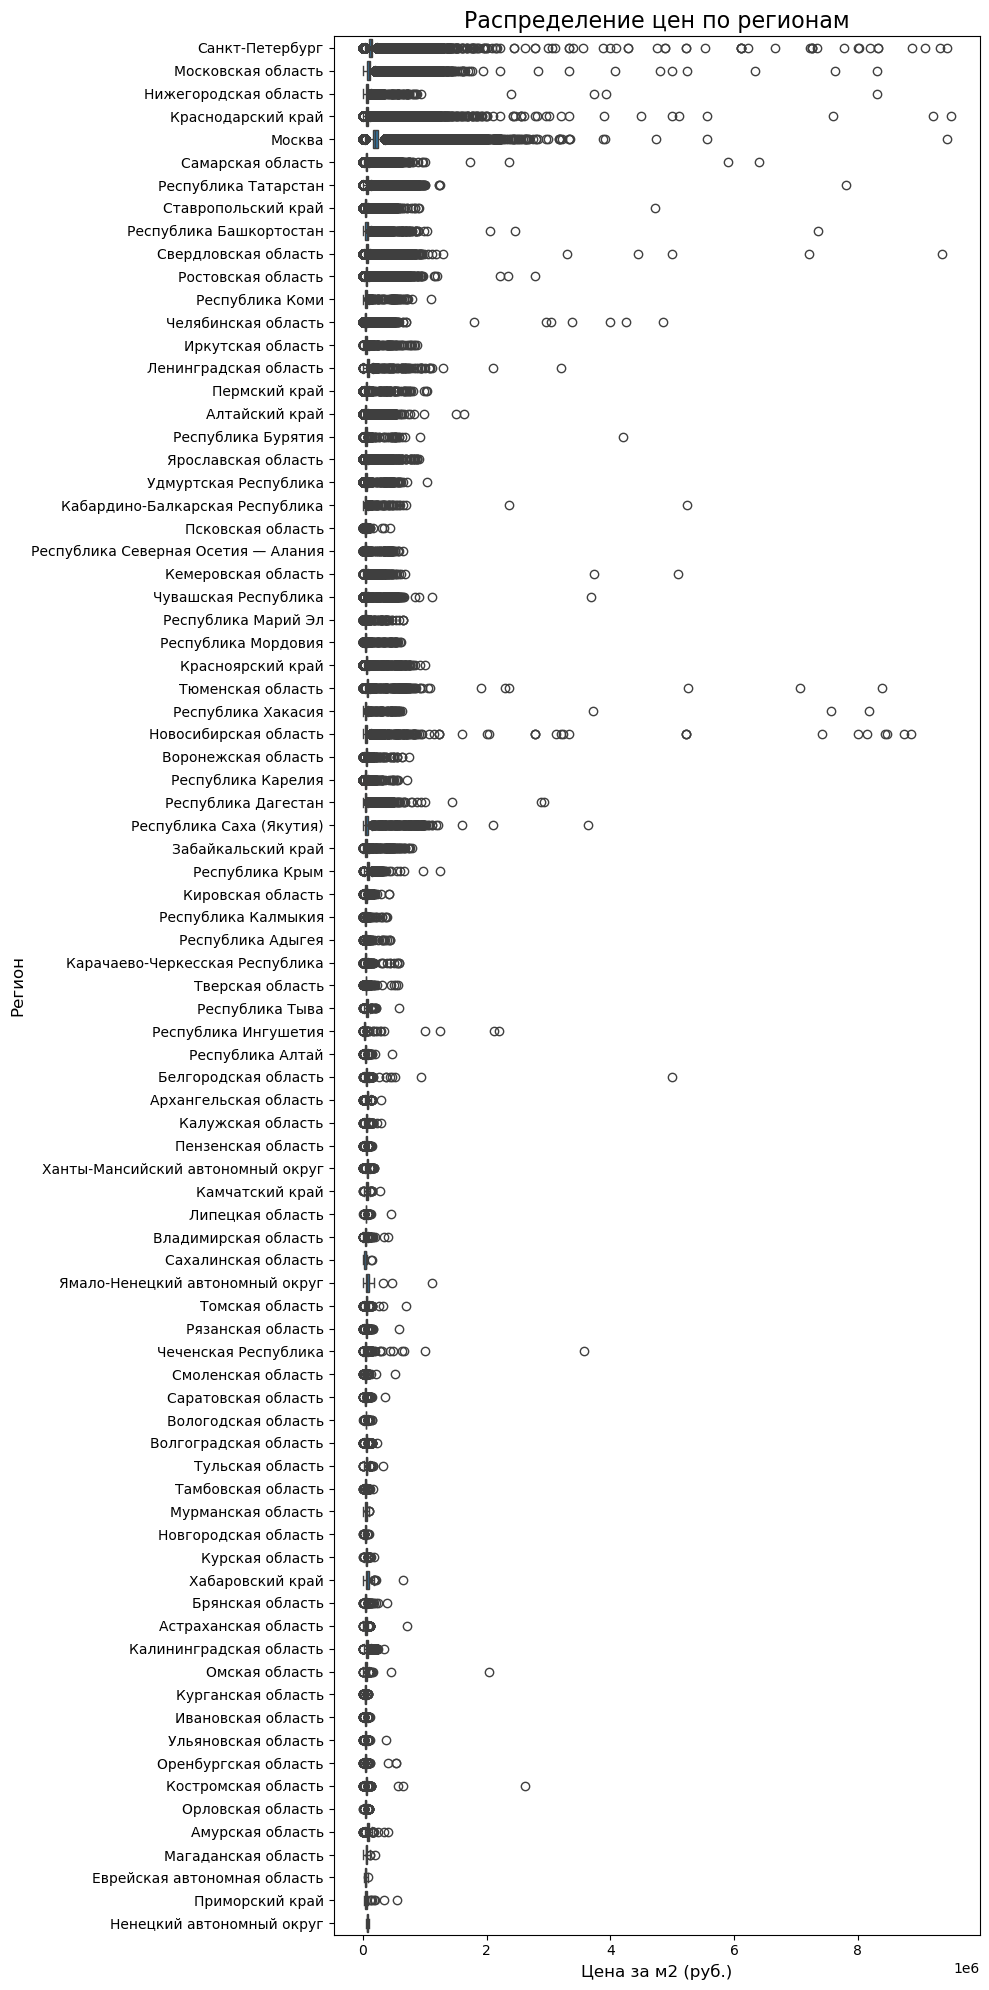

In [41]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, y='reg_name', x='price_m2', showfliers=True, orient='h')
plt.title('Распределение цен по регионам', fontsize=16)
plt.xlabel('Цена за м2 (руб.)', fontsize=12)
plt.ylabel('Регион', fontsize=12)
plt.tight_layout()
plt.show()

**Выбросов много даже у Москвы, это связано с тем, что данные в файле предтавлены за 2018-2021 год, а цены на Циан представлены текущие, т.е. за 2024 год. За 3 года цены очень выросли. Поставим еще раз верхнюю границу, ориентируясь на Москву. Граница составит 2.7е6, а для некоторых регионов поставим границу 1.2е6**

In [42]:
df = df[df['price_m2'] <= 2.7e6]
cities_iscl = ('Санкт-Петербург', 'Московская область', 'Краснодарский край', 'Москва')
df = df[~((df['price_m2'] > 1.2e6) & (~(df['reg_name'].isin(cities_iscl))))]

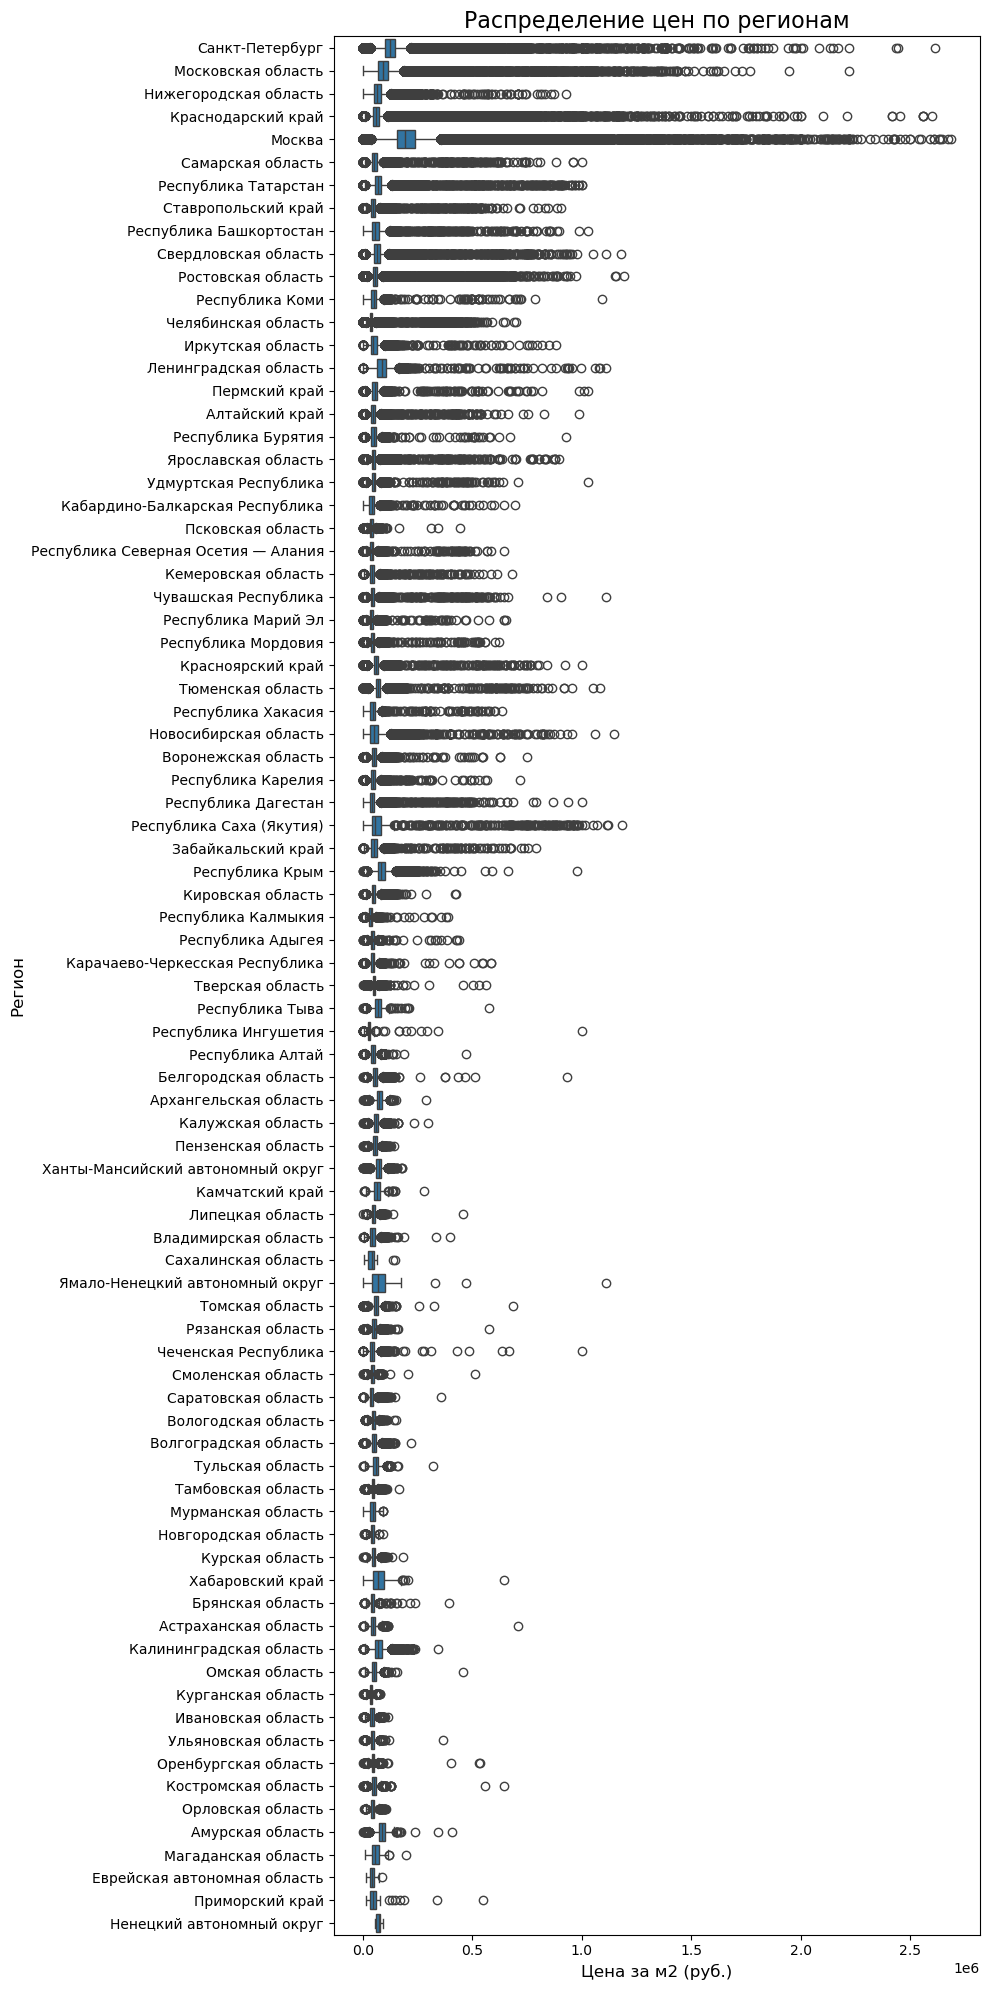

In [43]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, y='reg_name', x='price_m2', showfliers=True, orient='h')
plt.title('Распределение цен по регионам', fontsize=16)
plt.xlabel('Цена за м2 (руб.)', fontsize=12)
plt.ylabel('Регион', fontsize=12)
plt.tight_layout()
plt.show()

**На боксплоте заметим, что у регионов разное количество очень далеких выбросов, поэтому какие-то регионы нуждаются в большем удалении выбросов, какие-то в меньшем. Испропобовав много разных вариантов по работе с выбросами (MAD, LOF, DBSCAN, One-Class SVM), которые не приводили к желаемому результу, т.к. некоторые в принципе очень долгие и не направлены на работу с большим кол-вом значений, MAD удалял слишком много значений даже при широких границах. В итоге, я вернулась к Процентильному методу, где для некоторых регионов задала индивидуальные процентили, чтобы не потерять много хороших значений. Такой подход поможет нам исключить экстремальеые выбросы, не влияя на обработку основной массы данных и не даст удалить "хорошие" значения**

In [44]:
def assign_percentiles_by_region(df):

    #особое применение процентильных границ к регионам на основе их распределения.
    region_percentiles = {
        'Москва': {'lower': 0.001, 'upper': 0.999},
        'Санкт-Петербург': {'lower': 0.001, 'upper': 0.999},
        'Московская область': {'lower': 0.001, 'upper': 0.999},
        'Краснодарский край': {'lower': 0.005, 'upper': 0.995},
        'Ярославская область': {'lower': 0.005, 'upper': 0.995},
        'Иркутская область': {'lower': 0.005, 'upper': 0.995},
        'Республика Коми': {'lower': 0.005, 'upper': 0.995},
        'Нижегородская область': {'lower': 0.005, 'upper': 0.995},
        'Ленинградская область': {'lower': 0.005, 'upper': 0.995},
        'Республика Татарстан': {'lower': 0.005, 'upper': 0.995},
        #все остальные регионы по умолчанию
    }
    
    initial_count = len(df)  #общее количество строк до фильтрации
    result = []
    regions = df['reg_name'].unique()

    for region in regions:
        region_df = df[df['reg_name'] == region].copy()

        #получаем границы для каждого региона
        percentiles = region_percentiles.get(region, {'lower': 0.01, 'upper': 0.99})
        lower_quantile = percentiles['lower']
        upper_quantile = percentiles['upper']

        #рассчитываем границы
        lower = region_df['price_m2'].quantile(lower_quantile)
        upper = region_df['price_m2'].quantile(upper_quantile)

        #применяем фильтрацию
        region_df = region_df[
            (region_df['price_m2'] >= lower) &
            (region_df['price_m2'] <= upper)
        ]
        result.append(region_df)

    #объединяем результаты
    cleaned_df = pd.concat(result, ignore_index=True)
    
    #вычисляем количество удалённых выбросов
    removed_count = initial_count - len(cleaned_df)
    print(f"Количество удалённых выбросов: {removed_count}")
    
    return cleaned_df

#обновляем датафрейм
df = assign_percentiles_by_region(df)

Количество удалённых выбросов: 67946


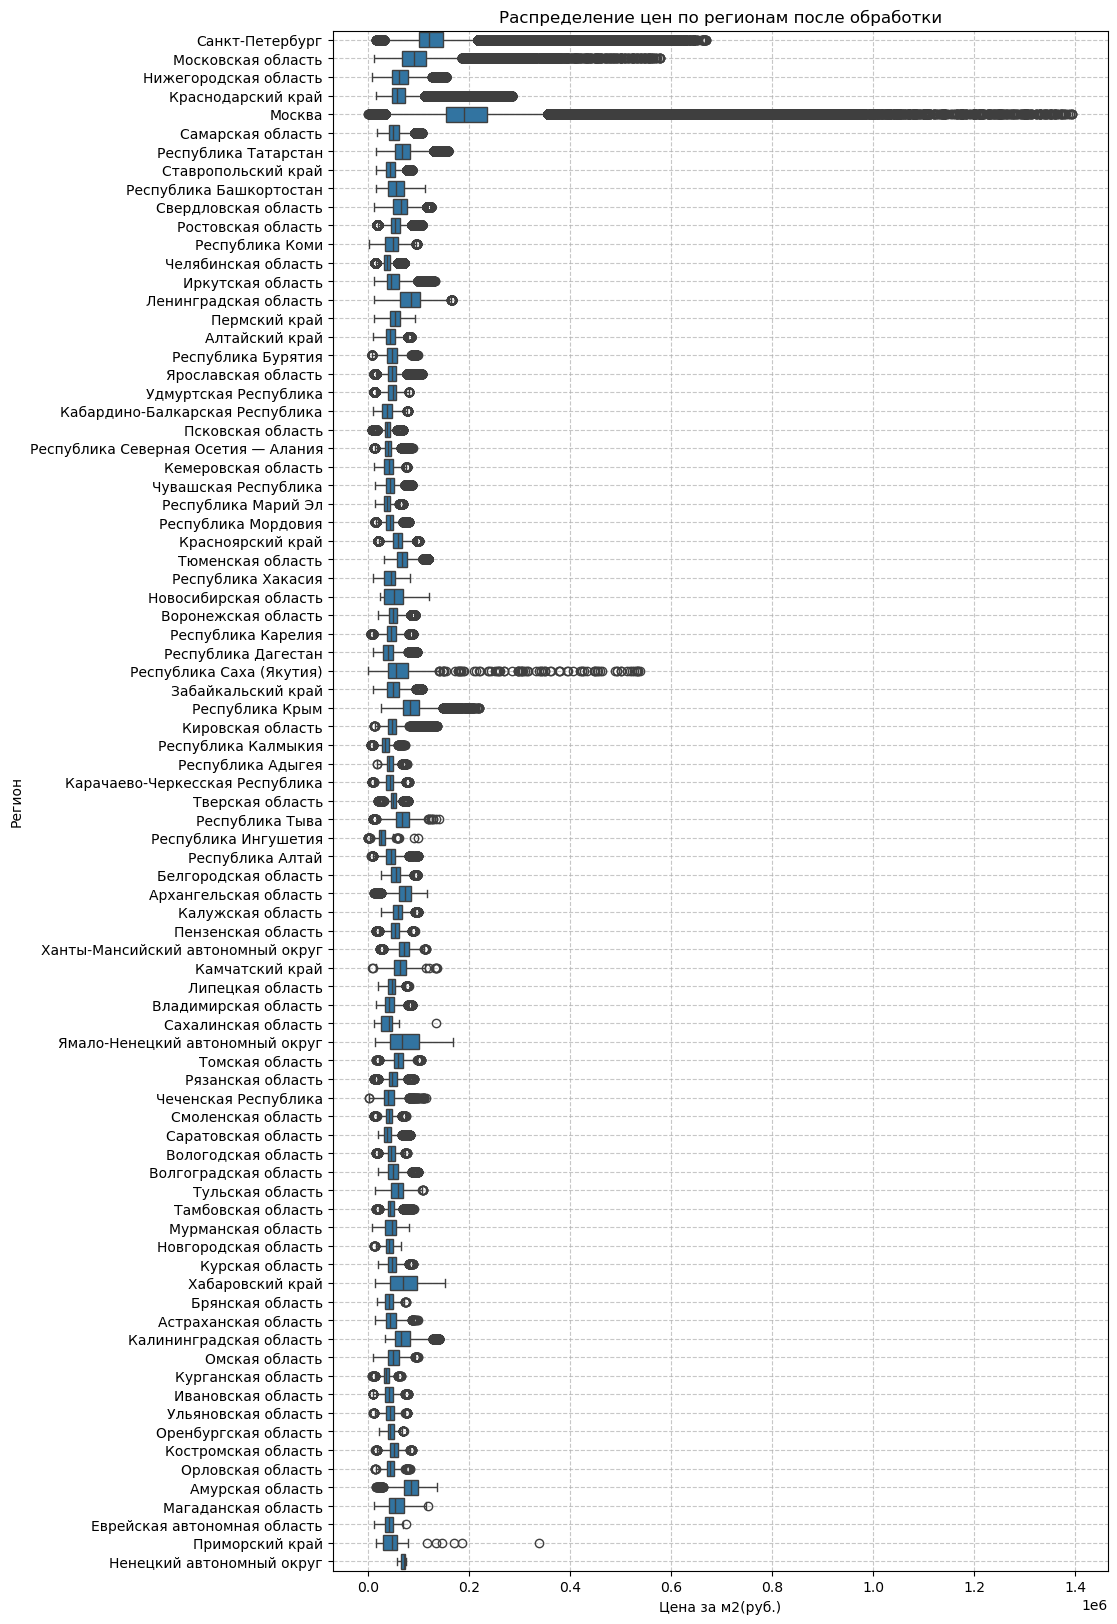

In [45]:
#посмотрим итоговое распределение
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x='price_m2', y='reg_name')
plt.title('Распределение цен по регионам после обработки')
plt.xlabel('Цена за м2(руб.)')
plt.ylabel('Регион')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**Кол-во выбросов удоговоримо, распределение цен выглядит заметно лучше. При этом, мы учитывали особенность каждого региона и распределение цен внутри них. Осталось несколько регионов, где явные выбросы остались, удалим их вручную.**

In [46]:
df = df[~((df['reg_name'] == 'Приморский край') & (df['price_m2'] > 100000))]
df = df[~((df['reg_name'] == 'Сахалинская область') & (df['price_m2'] > 65000))]

**Теперь увидим, что у нас есть очень маленькая цена, что тоже считается аномальным. Процентиль не помог, т.к. нижняя граница может быть отрицательной или очень маленькой. Я не боялась "превращать" цену квартиры в цену за м2, т.к. такие случаи как, например, 10 млн рублей стоит 90м2 попадут в аномально низкие значения и удалятся (точно также как бы и удалились как выбросы, превышающие заданное максимальное значение). Пусть минимальная стоимость м2 в составляет 5 тыс, для Москвы возьмем значение 20 тыс (цены взяты без учета долевых покупок)**

In [47]:
#Посмотрим сколько строк выше 5 млн рублей вне Москвы
df.loc[(df['price_m2'] < 20000) & (df['reg_name'] == 'Москва')]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2
1678723,700000,2018-09-12,3,3,3,5,2,45.0,NaN,False,Москва,15555
1681196,1000000,2018-09-18,3,3,5,10,3,60.0,10.0,False,Москва,16666
1681616,16600000,2018-09-18,3,2,23,25,4,961.0,13.4,True,Москва,17273
1683887,1270000,2018-09-24,3,3,2,5,2,72.0,14.0,False,Москва,17638
1684253,1100000,2018-09-24,3,3,4,4,3,58.0,7.0,False,Москва,18965
...,...,...,...,...,...,...,...,...,...,...,...,...
2098166,498000,2021-04-15,3,2,2,14,2,56.4,10.0,False,Москва,8829
2100641,450000,2021-04-21,3,3,1,2,1,38.0,8.0,False,Москва,11842
2103014,1850000,2021-04-26,3,2,2,10,4,138.0,13.0,False,Москва,13405
2108337,7327000,2021-05-01,3,2,28,30,5,528.0,50.0,False,Москва,13876


In [48]:
df.loc[df['price_m2'] < 5000]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2
1698055,300000,2018-10-23,3,3,1,5,3,85.0,8.0,False,Москва,3529
1719311,2800000,2018-12-03,3,1,6,9,3,648.0,9.0,False,Москва,4320
1724901,2790000,2018-12-15,3,1,1,5,1,766.0,13.0,False,Москва,3642
1753831,100000,2019-02-09,3,1,3,14,3,75.0,11.0,False,Москва,1333
1775541,189600,2019-03-30,3,1,2,12,4,79.3,8.4,False,Москва,2390
...,...,...,...,...,...,...,...,...,...,...,...,...
5077143,2200000,2020-09-28,2885,1,4,4,3,541.0,8.0,False,Чеченская Республика,4066
5077178,3000050,2020-10-05,2885,3,2,4,3,1000.0,50.0,False,Чеченская Республика,3000
5077182,1100000,2020-10-07,2885,3,1,2,6,305.0,8.0,False,Чеченская Республика,3606
5077343,3299000,2020-11-13,2885,2,2,5,2,700.0,15.0,False,Чеченская Республика,4712


**Количество выбросов удоговоримое, можем спокойно их удалить**

In [49]:
df = df[df['price_m2'] >= 5000]
mow_min = ['Москва']
df = df[~((df['price_m2'] < 20000) & (df['reg_name'].isin(mow_min)))]

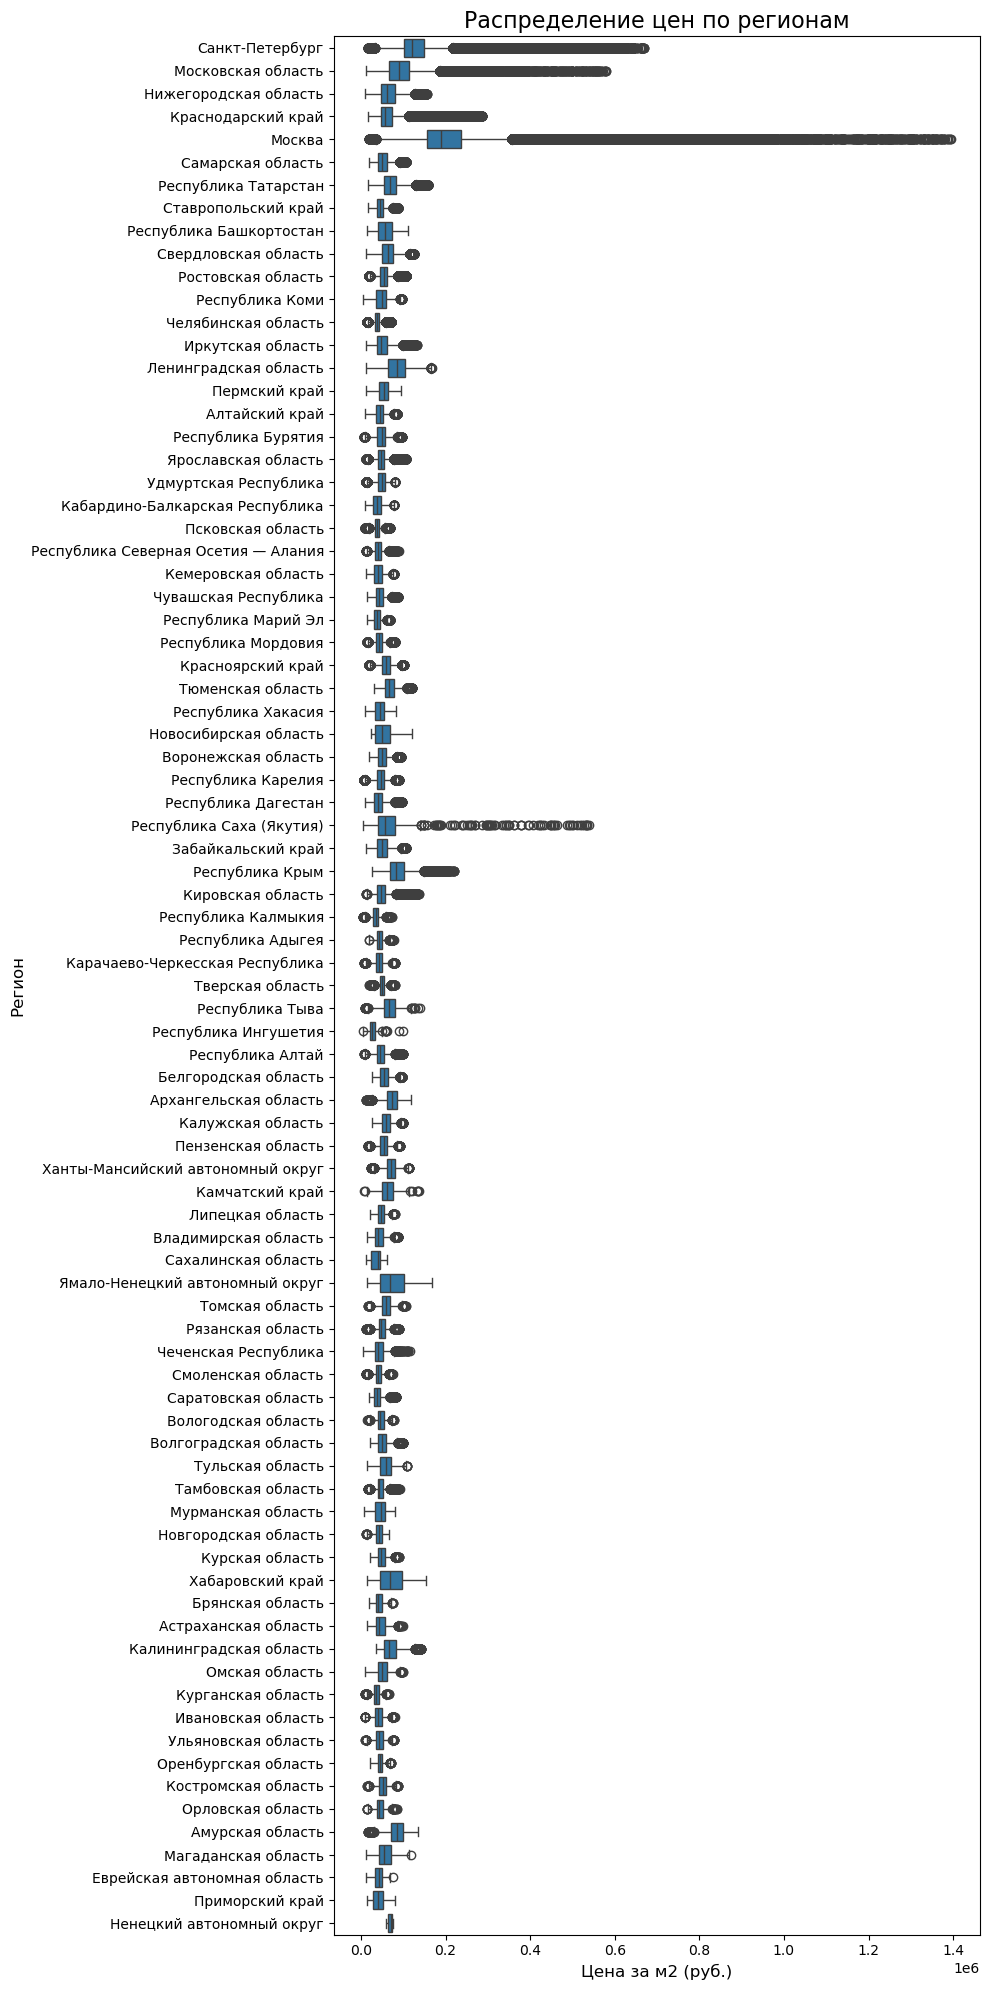

In [50]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, y='reg_name', x='price_m2', showfliers=True, orient='h')
plt.title('Распределение цен по регионам', fontsize=16)
plt.xlabel('Цена за м2 (руб.)', fontsize=12)
plt.ylabel('Регион', fontsize=12)
plt.tight_layout()
plt.show()

In [51]:
df.shape

(5171255, 12)

In [159]:
print(f'Количество удаленных выбросов по столбцу "price": {5241351 - 5171255}')
print(f'Количество удаленных выбросов по столбцу "price" в процентах: {((70096*100)/5477006):.2f}')

Количество удаленных выбросов по столбцу "price": 70096
Количество удаленных выбросов по столбцу "price" в процентах: 1.28


<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

***ВЫВОД ПО СТОЛБЦУ PRICE***

**Данный столбец содержал 3 вида аномалий: отрицательные цены, слишком высокие цены, слишком маленькие цены. Отрицательный цены были удалены, т.к. их было немного и они сильно отличались от реальности. Т.к. Москва сильно отличается по ценам даже от Московской области, для нее нужны были отдельные данные, при обработке выбросов. Таким образом, сначала датафрейм был обработан от цен за всю квартиру, путем переделывания их в стоимость за м2. Слишком большие значения были удалены по приблизительным значениям, точно также были обработаны и слишком маленькие значения. В итоге было удалено меньше 2% всего датафрейма, что не может не радовать**
</div>

<a id='33-аномалии-этаж'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 3.3 Аномалии столбцов level & levels
</div>

[Вернуться к содержанию](#задачи)

**Аномалия, которая может наблюдаться по этим двум столбцам одна - этаж, на котором находится квартира, выше чем всего этажей в доме. Посмотрим есть ли у нас такие записи**

In [53]:
#проверяем наличие отрицательных столбцов
negative_counts = (df['levels'] < 0).sum()
negative_count = (df['level'] < 0).sum()

print(f'Количество отрицательных значений в столбце "levels": {negative_counts}')
print(f'Количество отрицательных значений в столбце "level": {negative_count}')

Количество отрицательных значений в столбце "levels": 0
Количество отрицательных значений в столбце "level": 0


In [54]:
error_levels = df[df['level'] > df['levels']]
error_levels

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2
51834,3500000,2018-12-19,2661,3,23,10,1,94.0,12.0,False,Санкт-Петербург,37234
52048,2400000,2018-12-19,2661,3,12,8,1,55.0,12.0,False,Санкт-Петербург,43636
52055,3500000,2018-12-19,2661,3,23,10,3,94.0,12.0,False,Санкт-Петербург,37234
52109,2800000,2018-12-19,2661,3,16,9,2,78.0,12.0,False,Санкт-Петербург,35897
52122,2400000,2018-12-20,2661,3,12,8,1,55.0,12.0,False,Санкт-Петербург,43636
...,...,...,...,...,...,...,...,...,...,...,...,...
4926758,1400000,2018-12-24,10160,3,15,9,2,75.0,12.0,False,Забайкальский край,18666
4942862,3500000,2020-06-16,10160,3,13,4,1,58.0,18.0,False,Забайкальский край,60344
4957923,6800000,2019-09-04,2594,3,5,3,3,61.0,6.0,False,Кировская область,111475
4972766,3000000,2019-11-01,11991,3,12,2,3,76.0,7.0,False,Карачаево-Черкесская Республика,39473


**Таких записей оказалось 636. Просто поменяем этаж квартиры и общее количество этажей в доме местами для них**

In [55]:
error_levels = df['level'] > df['levels']
df.loc[error_levels, ['level', 'levels']] = df.loc[error_levels, ['levels','level']].values
#меняем значения столбцов местами для аномальных строк

<a id='34-аномалии-площадь'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 3.4 Аномалии столбцов room -> area -> kitchen_area
</div>

[Вернуться к содержанию](#задачи)

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

### 3.4.1 Аномалии по столбцам area & kitchen_area
</div>

**Тут может быть такая же ситуация, как и с этажами, т.е. площадь кухни больше площади квартиры, проверим это**

In [56]:
error_area = df[df['kitchen_area'] > df['area']]
error_area

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2
21875,4850000,2018-10-08,2661,1,1,9,1,10.00,17.0,False,Санкт-Петербург,485000
24485,4950000,2018-10-12,2661,1,6,17,1,39.00,108.0,False,Санкт-Петербург,126923
75875,6250000,2019-02-27,2661,2,4,5,2,60.00,113.0,False,Санкт-Петербург,104166
78144,6380000,2019-03-04,2661,3,3,6,2,42.00,58.0,False,Санкт-Петербург,151904
100099,3200000,2019-04-27,2661,1,2,5,3,62.70,93.0,False,Санкт-Петербург,51036
...,...,...,...,...,...,...,...,...,...,...,...,...
5115944,1450000,2020-01-25,7896,3,3,15,1,22.40,50.0,False,Калининградская область,64732
5127098,1876350,2020-06-04,7896,0,2,4,1,33.57,132.0,True,Калининградская область,55893
5128111,2044200,2020-06-23,7896,0,2,4,1,33.57,132.0,True,Калининградская область,60893
5139140,2590000,2020-10-20,7896,1,8,9,1,33.10,80.0,False,Калининградская область,78247


**Действительно, такие записи есть. Пока не будем обращать внимание на слишком маленькие значения, обработает это позже. Сейчас в этих строках просто поменяем площадь местами**

In [57]:
error_area = df['kitchen_area'] > df['area']
df.loc[error_area, ['kitchen_area', 'area']] = df.loc[error_area, ['area','kitchen_area']].values
#меняем значения столбцов местами для аномальных строк

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

### 3.4.2 Аномалии по столбцу rooms
</div>

In [58]:
df['rooms'].unique() #смотрим уникальные значения по столбцу

array([ 3,  1,  2, -1,  4,  6,  5,  7,  8,  9, -2, 10], dtype=int64)

**Принято считать, что максимальное количество комнат в квартире - 6. Но бывают и иссключения, например, исторические здания, объединенные квартиры и т.п., оставим их.**

**По столбцу rooms найдена уникальная запись -2, для которой у нас нет описания. Сделаем два предположения: это двушка, минус появился случайно; это студия, -2 ошибочно, нужно заменить на -1**

In [59]:
df.loc[df['rooms'] == -2]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2
15372,25500000,2018-09-18,2661,3,1,7,-2,360.0,22.0,False,Санкт-Петербург,70833
16655,3150000,2018-09-21,2661,2,2,17,-2,35.0,9.0,False,Санкт-Петербург,90000
18643,29500000,2018-09-26,2661,3,5,7,-2,356.0,18.9,False,Санкт-Петербург,82865
19179,29990000,2018-09-27,2661,3,5,6,-2,303.0,18.9,False,Санкт-Петербург,98976
23682,16500000,2018-10-11,2661,3,5,5,-2,217.0,18.0,False,Санкт-Петербург,76036
...,...,...,...,...,...,...,...,...,...,...,...,...
4885624,2900000,2019-03-23,4007,3,2,4,-2,90.0,20.0,False,Республика Дагестан,32222
4892445,45000000,2019-09-04,4007,3,1,9,-2,1000.0,30.0,True,Республика Дагестан,45000
4923948,32000000,2018-10-02,10160,3,3,3,-2,456.0,22.0,False,Забайкальский край,70175
5006433,40000000,2020-03-15,5952,3,10,11,-2,490.0,10.0,True,Белгородская область,81632


**Значения очень различны. Поиски на Циан показали, что двушка может быть и площадью 415м2 и даже больше, даже если это не Москва. Также двушка может быть и около 38м2 (эконом класс, евродвушка). Поэтому, не обращая внимания на совсем маленькие значения (10 и ниже, они обработаются позже), сделаем вывод, что -2 все-таки 2-комнатые квартиры, перед которыми - появился случайно. Например, из-за копирования данных с определенного сайта, неправильный ввод данных и т.п.**

**Также было предположение, что -2 может обозначать квартиры свободной планировки. Но, у таких квартир в технической документации все равно есть "физические стены" т.е. если в ряду, где находится квартира свободной планировки, все квартиры двушки, то и эта квартира считается 2-комнатной технически**

In [60]:
df['rooms'] = df['rooms'].replace(-2,2) 
#меняем значение -2 на 2

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

### 3.4.3 Обработка значений площади квартиры
</div>

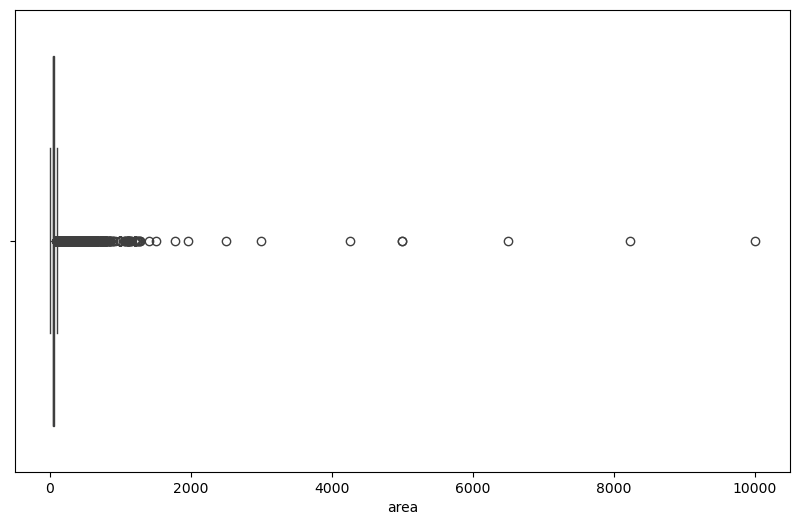

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['area'], orient='h');

**Площадь квартиры доходит до 10к м2, что конечно же считается аномальным. Для Санкт-Петербурга и Москвы вырхняя граница будет 1800 м2 (пентхаусы), для остальных регионов 550 м2. А вот нижнюю границы поставим для всех одинаковую - 12м2 (студии)**

In [62]:
df.loc[df['area'] > 550]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2
18151,395000000,2018-09-25,2661,3,4,6,6,650.0,100.0,False,Санкт-Петербург,607692
19972,395000000,2018-09-30,2661,1,9,9,7,766.0,23.0,True,Санкт-Петербург,515665
36369,60000000,2018-11-10,2661,3,4,4,2,631.0,30.0,False,Санкт-Петербург,95087
67126,140000000,2019-02-07,2661,3,4,4,2,631.2,19.5,False,Санкт-Петербург,221799
95635,103000000,2019-04-16,2661,3,3,5,2,591.1,20.0,False,Санкт-Петербург,174251
...,...,...,...,...,...,...,...,...,...,...,...,...
5076351,6000000,2020-04-07,2885,3,2,5,3,875.0,7.0,True,Чеченская Республика,6857
5076672,5000000,2020-07-02,2885,3,3,5,3,1000.0,100.0,False,Чеченская Республика,5000
5077096,3500000,2020-09-20,2885,2,12,12,3,663.0,20.0,False,Чеченская Республика,5279
5077101,3500000,2020-09-21,2885,3,2,2,3,600.0,6.0,False,Чеченская Республика,5833


In [63]:
df.loc[df['area'] < 12]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2
38174,1560000,2018-11-14,2661,3,1,9,-1,11.4,2.0,False,Санкт-Петербург,136842
40169,1650000,2018-11-19,2661,3,1,5,-1,11.9,2.0,False,Санкт-Петербург,138655
49468,1250000,2018-12-11,2661,3,1,4,-1,11.0,3.0,False,Санкт-Петербург,113636
50511,1800000,2018-12-14,2661,3,8,12,1,4.9,1.1,False,Санкт-Петербург,367346
110164,5000000,2019-05-26,2661,3,1,1,-1,10.0,5.0,True,Санкт-Петербург,500000
...,...,...,...,...,...,...,...,...,...,...,...,...
4972219,750000,2019-08-12,11991,3,2,5,2,11.0,11.0,False,Карачаево-Черкесская Республика,68181
5035066,370000,2019-11-08,6543,3,4,5,2,6.0,4.4,False,Архангельская область,84090
5066362,790000,2020-12-01,5789,1,1,10,-1,11.1,2.0,True,Владимирская область,71171
5069972,550000,2020-03-30,10201,3,6,9,1,11.0,3.0,False,Томская область,50000


In [64]:
#удаляем выбросы выше верхних значений
df = df[df['area'] <= 1800]

area_exception = ['Москва', 'Санкт-Петербург']
df = df[~((df['area'] > 550) & (~df['reg_name'].isin(area_exception)))]

In [65]:
#удаляем выбросы ниже минимального значения
df = df[~(df['area'] < 12)]

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

### 3.4.4 Обработка площади квартиры в зависимости от количества комнат
</div>

**Площадь квартиры, конечно же, зависит от количества комнат. Однако верхнюю границу подобрать очень тяжело, они довольно размыты. Для каждого количества комнат поставим минимальную границу площади, чтобы грамонтно удалить выбросы**

Нижние границы установлены следующие:
- студия: 12 м2
- 1-комнатная: 25 м2
- 2-комнатная: 38 м2
- 3-комнатная: 53 м2
- 4-комнатная: 65 м2
- 5-комнатная: 77 м2
- 6-комнатная: 96 м2
- 7-10-комнатная: 109 м2

In [66]:
min_area = {
    -1: 12,   
    1: 25,   
    2: 38,   
    3: 53,   
    4: 65,   
    5: 77,   
    6: 96,
    7: 109,
    8: 109,
    9: 109,
    10: 109
}

In [67]:
#добавим новый столбец
df['min_area'] = df['rooms'].map(min_area)

In [68]:
df.sample(3)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2,min_area
3061059,1510000,2019-02-12,5282,1,2,9,1,34.0,9.0,False,Челябинская область,44411,25
3532191,2913000,2020-10-23,1010,3,2,14,2,60.0,12.0,False,Удмуртская Республика,48550,38
3253478,1090000,2020-11-19,3446,1,5,5,1,41.0,9.0,False,Ленинградская область,26585,25


In [69]:
#смотрим сколько строк содержат значения площади квартиры меньше, чем минимальная площадь квартир
mins = df[df['area'] < df['min_area']]
mins

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2,min_area
135,1975830,2018-09-08,2661,2,5,12,1,20.1,5.0,True,Санкт-Петербург,98300,25
216,3950000,2018-09-08,2661,1,2,5,3,42.0,5.0,False,Санкт-Петербург,94047,53
223,2700000,2018-09-08,2661,1,5,9,1,23.0,5.0,False,Санкт-Петербург,117391,25
225,2650000,2018-09-08,2661,1,1,9,1,22.6,5.0,False,Санкт-Петербург,117256,25
275,4090000,2018-09-08,2661,1,4,5,3,42.0,5.6,False,Санкт-Петербург,97380,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5172401,1800000,2019-05-02,4963,3,2,2,2,36.8,6.0,False,Приморский край,48913,38
5172402,1008888,2019-05-07,4963,3,2,2,2,35.5,6.1,False,Приморский край,28419,38
5172411,2100000,2019-10-04,4963,1,4,5,2,34.0,7.7,False,Приморский край,61764,38
5172414,1300000,2019-10-22,4963,1,5,5,3,43.5,9.0,False,Приморский край,29885,53


In [70]:
print(f'Процент значенений, которые меньше минимальной площади: {(150665*100)/len(df):.2f}')

Процент значенений, которые меньше минимальной площади: 2.92


**2,92%  от текущего датафрейма не играет сильно важную роль, поэтому можем удалить аномально низкую площадь**

In [71]:
df = df[df['area'] >= df['min_area']]

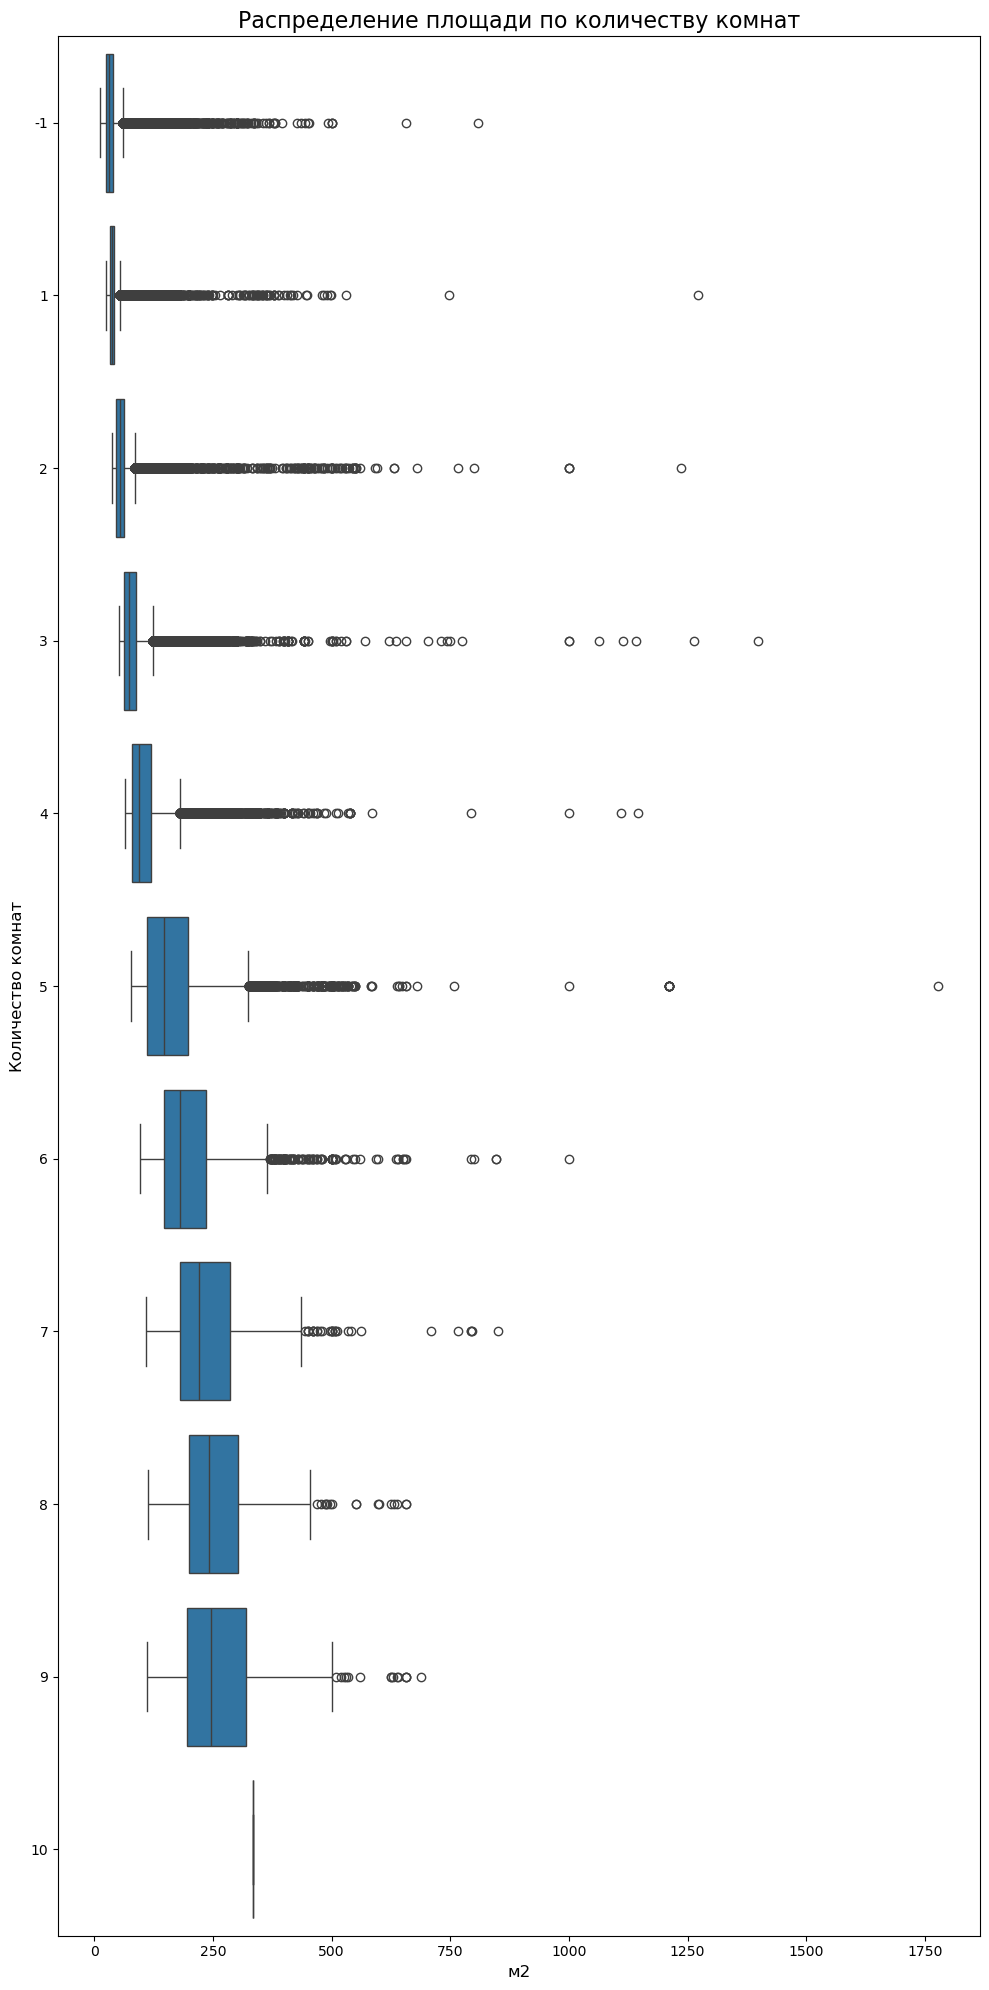

In [72]:
#посмотрим распределение площади по комнатам
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, y='rooms', x='area', showfliers=True, orient='h')
plt.title('Распределение площади по количеству комнат', fontsize=16)
plt.xlabel('м2', fontsize=12)
plt.ylabel('Количество комнат', fontsize=12)
plt.tight_layout()
plt.show()

In [73]:
#вручную удаляем слишком далекие выбросы
df = df[~((df['rooms'] == -1) & (df['area'] > 400))]
df = df[~((df['rooms'] == 1) & (df['area'] > 410))]
df = df[~((df['rooms'] == 2) & (df['area'] > 550))]
df = df[~((df['rooms'] == 3) & (df['area'] > 420))]
df = df[~((df['rooms'] == 4) & (df['area'] > 420))]
df = df[~((df['rooms'] == 5) & (df['area'] > 575))]
df = df[~((df['rooms'] == 6) & (df['area'] > 510))]
df = df[~((df['rooms'] == 7) & (df['area'] > 510))]
df = df[~((df['rooms'] == 8) & (df['area'] > 510))]
df = df[~((df['rooms'] == 9) & (df['area'] > 510))]

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

### 3.4.5 Обработка площади кухни в зависимости от площади квартиры
</div>

**Довольно сложная аномалия для понимания. Ведь метраж комнат в т.ч. и кухни определяется застройщиком и почти не имеет никаких ограничений. Мною была найдена информация, что минимально кухня может составлять 5% от площади квартиры, а максимально - 45%. Посмотрим сколько значений останется за пределами заданного интервала**

In [74]:
#задаём границы как проценты от площади квартиры
min_percent = 0.05  #минимум: 5%
max_percent = 0.45  #максимум: 45%

In [75]:
#создадим новые столбцы, которые содержат информацию о минимальной и максимальной допустимой площади для каждой квартиры
df['min_kitchen_area'] = df['area'] * min_percent
df['max_kitchen_area'] = df['area'] * max_percent

In [76]:
#смотрим сколько значений находится за пределами интервала
wrong_kitchen = df[
    (df['kitchen_area'] < df['min_kitchen_area']) |
        (df['kitchen_area'] > df['max_kitchen_area']) 
       
    
]
wrong_kitchen

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2,min_area,min_kitchen_area,max_kitchen_area
395,5000000,2018-09-09,2661,1,12,13,2,47.7,28.2,False,Санкт-Петербург,104821,38,2.385,21.465
410,11000000,2018-09-09,2661,2,13,16,2,50.0,23.0,False,Санкт-Петербург,220000,38,2.500,22.500
437,4400000,2018-09-09,2661,3,9,17,1,46.0,25.0,False,Санкт-Петербург,95652,25,2.300,20.700
442,2340819,2018-09-09,2661,2,9,15,-1,25.7,17.6,True,Санкт-Петербург,91082,12,1.285,11.565
468,4515000,2018-09-09,2661,2,9,25,1,41.0,20.0,True,Санкт-Петербург,110121,25,2.050,18.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5170606,4300000,2020-05-22,7929,3,4,4,1,43.0,23.0,False,Амурская область,100000,25,2.150,19.350
5171250,2750000,2020-10-01,7929,3,5,5,3,63.4,46.4,False,Амурская область,43375,53,3.170,28.530
5171816,9900000,2021-02-28,7929,3,8,15,3,94.4,46.4,False,Амурская область,104872,53,4.720,42.480
5171849,4830700,2021-03-09,7929,3,4,12,1,47.0,22.0,False,Амурская область,102780,25,2.350,21.150


In [77]:
print(f'Процент значенений, которые меньше минимальной площади: {(108972*100)/len(df):.2f}')

Процент значенений, которые меньше минимальной площади: 2.17


**Границы для кухни поставлены максимально и минимально возможны. Остальные случаи являются или невозможными, или очень редкими. Выбросы по столбцу площади кухни составляют меньше 2,5% от текущего размера датафрейма. Удалим их**

In [78]:
df = df[
    (
        (df['kitchen_area'] >= df['min_kitchen_area']) & 
        (df['kitchen_area'] <= df['max_kitchen_area']) |
        df['kitchen_area'].isna()  #сохраняем строки с NaN, чтобы случайно не удалить их
    )
]

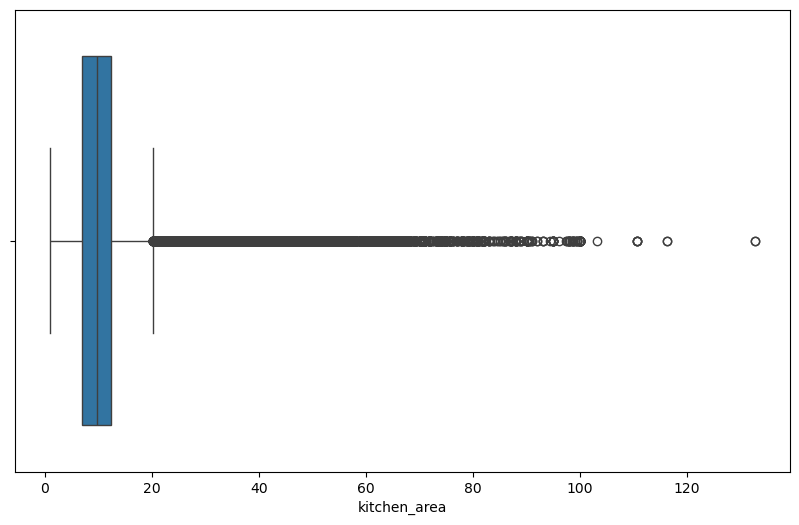

In [79]:
#посмотрим распределение кухни
plt.figure(figsize=(10, 6))
sns.boxplot(df['kitchen_area'], orient='h');

**Площадь кухни выглядит удоговоримо**

In [80]:
#посмотрим сколько строк содержат площадь кухни меньше минимальной
df.loc[df['kitchen_area'] < 4]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2,min_area,min_kitchen_area,max_kitchen_area
66,1950000,2018-09-08,2661,4,7,24,1,25.5,2.0,True,Санкт-Петербург,76470,25,1.275,11.475
230,1999000,2018-09-08,2661,1,14,16,-1,23.5,2.0,False,Санкт-Петербург,85063,12,1.175,10.575
388,1950000,2018-09-09,2661,1,1,9,-1,18.0,2.0,False,Санкт-Петербург,108333,12,0.900,8.100
443,3100000,2018-09-09,2661,2,4,12,-1,24.0,2.0,False,Санкт-Петербург,129166,12,1.200,10.800
512,3300000,2018-09-09,2661,2,9,17,-1,26.0,2.0,False,Санкт-Петербург,126923,12,1.300,11.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171053,2950000,2020-08-12,7929,3,7,10,1,27.0,2.0,False,Амурская область,109259,25,1.350,12.150
5171876,3300000,2021-03-12,7929,3,1,3,1,27.0,3.0,False,Амурская область,122222,25,1.350,12.150
5171966,1944000,2021-03-29,7929,3,3,3,-1,27.0,2.0,False,Амурская область,72000,12,1.350,12.150
5172399,808000,2019-04-21,4963,3,1,2,1,26.6,2.0,False,Приморский край,30375,25,1.330,11.970


**Критично маленьких значений много и удалять их не хочется. Заменим для таких значений площадь кухни на минимальную**

In [81]:
#заменяем значения в kitchen_area, которые меньше 4, на 4
df.loc[df['kitchen_area'] < 4, 'kitchen_area'] = 4

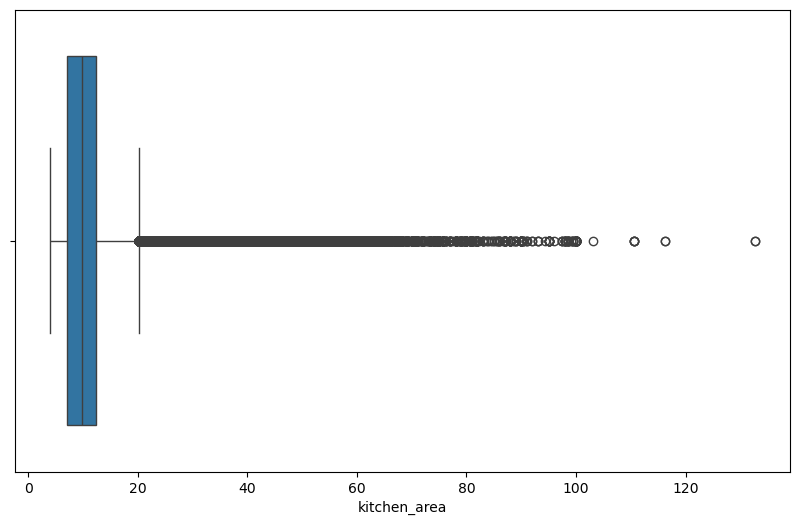

In [82]:
#посмотрим распределение кухни
plt.figure(figsize=(10, 6))
sns.boxplot(df['kitchen_area'], orient='h');

In [83]:
print(f'Количество удаленных выбросов по площади: {5172373 - len(df)}')
print(f'Количество удаленных выбросов по площади в процентах: {((258467*100)/5228147):.2f}')

Количество удаленных выбросов по площади: 263614
Количество удаленных выбросов по площади в процентах: 4.94


<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

***ВЫВОД ПО СТОЛБЦАМ, СОДЕРЖАЩИЕ ПЛОЩАДЬ И КОМНАТЫ***

**Эти три столбца тесно связаны друг с другом, поэтому требовали тщательного анализа и проработки. Была исправления аномалия в столбце с кол-вом комнат, путем замены значения "-2" по модулю. Далее были проработаны аномалии по площади (слишком высокие или низкие значения, отрицательные значения отсутствовали). На основе площади квартиры была рассчитана и площадь кухни. Важное примечание! Для студий у кухни тоже расчитывались границы, т.к. застройщики указывают ее метраж как ниша, несмотря на то, что технически в студиях кухни нет и они относятся к жилой площади. Выбросов получилось довольно много, однако избежать этого вряд-ли получилось бы, т.к. на это есть ряд причин. Во-первых, данные для границ были подобраны после тщательного исследования рынка недвижимости. Если бы были поставлены другие границы, данные бы потеряли "правдивость" и помешали бы в дальнейшем анализе. Во-вторых, выбросы по столбцам с площадью составляют вместе около 5% от всех данных, что, в целом, незначительно.**
</div>

<a id='35-аномалии-тип'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 3.5 Аномалии столбца building_type
</div>

[Вернуться к содержанию](#задачи)

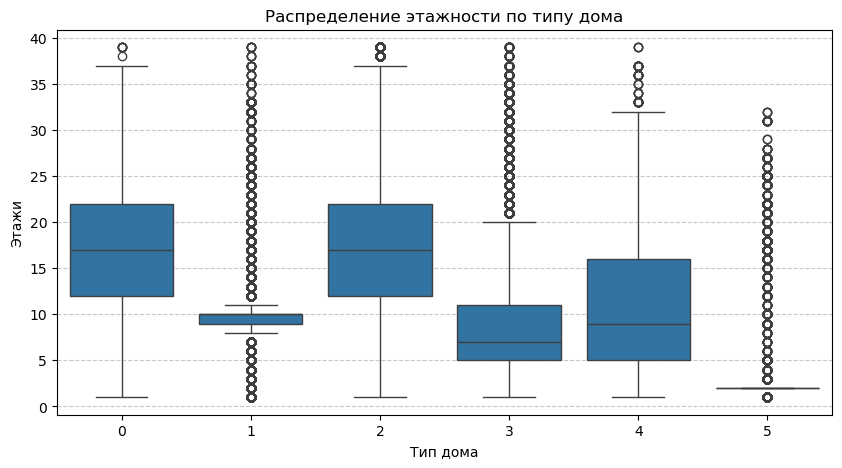

In [84]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='building_type', y='levels')
plt.title('Распределение этажности по типу дома')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Этажи')
plt.xlabel('Тип дома')
plt.show()

**Посмотрим на количество этажей для каждого из типа зданий и проверим их на адекватность. Если панельный и кирпично-монолитный типы зданий могут строиться высокими (~50 этажей), то кирпичный, блочный и деревянный точно нет. Поставим для них максимальное возможное значение и проверим на наличие аномалий. Тип зданий - другое может содержать разные материалы, поэтому для него установить максимальную этажность мы не можем**

- Кирпичный: Чисто кирпичные дома из-за веса материала редко превышают 5–10 этажей. Очень редко могут достигать 15 этажей в смешанной конструкции
- Блочный: Дома из пеноблоков или газобетона ограничены прочностью материала, поэтому не выше 10-16 этажей
- Деревянный: Ограничения по пожарной безопасности и устойчивости ограничивают этажность 2–3 уровнями. 


In [85]:
brick_type = df[(df['building_type'] == 3) & (df['levels'] > 15)]
brick_type

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2,min_area,min_kitchen_area,max_kitchen_area
12,7101000,2018-07-16,2661,3,3,25,2,63.8,13.0,False,Санкт-Петербург,111300,38,3.190,28.710
19,4800000,2018-08-30,2661,3,8,19,1,35.7,9.3,False,Санкт-Петербург,134453,25,1.785,16.065
26,10470000,2018-08-31,2661,3,9,22,2,72.4,14.0,False,Санкт-Петербург,144613,38,3.620,32.580
40,3750000,2018-09-08,2661,3,9,24,1,41.0,9.0,False,Санкт-Петербург,91463,25,2.050,18.450
49,6400000,2018-09-08,2661,3,3,16,3,68.0,8.0,False,Санкт-Петербург,94117,53,3.400,30.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5172082,10500000,2021-04-21,7929,3,13,16,2,90.0,15.0,False,Амурская область,116666,38,4.500,40.500
5172104,5000000,2021-04-24,7929,3,12,16,1,50.0,9.0,False,Амурская область,100000,25,2.500,22.500
5172115,7700000,2021-04-26,7929,3,12,16,2,71.0,14.0,False,Амурская область,108450,38,3.550,31.950
5172140,3670000,2021-04-30,7929,3,7,16,-1,30.0,5.0,False,Амурская область,122333,12,1.500,13.500


**Почти 300к строк выше заданного значения кирпичного типа здания. Удалять столько данных будет неправильно. Возможно, данные значения были ошибочно занесены в данный тип, а на самом деле являются постройками кирпично-монолитного типа. Занесем эти значения в тип здания "2"**

In [86]:
df.loc[(df['building_type'] == 3) & (df['levels'] > 15), 'building_type'] = 2

In [87]:
#обрабатываем типы данных дальше
block_type = df[(df['building_type'] == 4) & (df['levels'] > 16)]
block_type

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2,min_area,min_kitchen_area,max_kitchen_area
66,1950000,2018-09-08,2661,4,7,24,1,25.5,4.0,True,Санкт-Петербург,76470,25,1.275,11.475
1102,3550000,2018-09-11,2661,4,5,20,1,33.0,8.0,False,Санкт-Петербург,107575,25,1.650,14.850
1144,6900000,2018-09-11,2661,4,6,17,3,73.4,10.8,False,Санкт-Петербург,94005,53,3.670,33.030
1486,4500000,2018-09-11,2661,4,10,23,2,70.0,14.0,True,Санкт-Петербург,64285,38,3.500,31.500
2207,4800000,2018-09-13,2661,4,18,19,2,69.2,12.0,True,Санкт-Петербург,69364,38,3.460,31.140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5161981,2300000,2020-12-09,3153,4,2,17,1,44.0,10.0,False,Оренбургская область,52272,25,2.200,19.800
5162603,2676000,2021-02-18,3153,4,12,17,2,62.2,12.4,True,Оренбургская область,43022,38,3.110,27.990
5162659,1750000,2021-02-23,3153,4,12,17,1,36.0,9.0,False,Оренбургская область,48611,25,1.800,16.200
5163067,3500000,2021-03-27,3153,4,5,17,3,79.5,10.8,False,Оренбургская область,44025,53,3.975,35.775


In [88]:
#количество выбросов удоговоримо, удаляем
df = df[~((df['building_type'] == 4) & (df['levels'] > 16))]

In [89]:
wood_type = df[(df['building_type'] == 5) & (df['levels'] > 3)]
wood_type

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2,min_area,min_kitchen_area,max_kitchen_area
949,3805550,2018-09-10,2661,5,25,25,1,41.5,17.7,False,Санкт-Петербург,91700,25,2.075,18.675
950,3250060,2018-09-10,2661,5,6,25,1,37.4,14.3,False,Санкт-Петербург,86900,25,1.870,16.830
951,4676770,2018-09-10,2661,5,2,24,2,49.7,10.0,False,Санкт-Петербург,94100,38,2.485,22.365
952,3952590,2018-09-10,2661,5,20,24,1,36.7,10.0,False,Санкт-Петербург,107699,25,1.835,16.515
954,7585200,2018-09-10,2661,5,2,24,3,84.0,25.4,False,Санкт-Петербург,90300,53,4.200,37.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092465,2149000,2018-12-02,4695,5,6,14,1,39.0,14.0,False,Волгоградская область,55102,25,1.950,17.550
5099014,5500000,2021-04-09,4695,5,1,9,2,62.0,18.0,False,Волгоградская область,88709,38,3.100,27.900
5139283,3792000,2020-10-22,7896,5,1,10,2,63.2,NaN,True,Калининградская область,60000,38,3.160,28.440
5142618,3030000,2020-12-10,7896,5,6,9,2,57.2,11.4,True,Калининградская область,52972,38,2.860,25.740


In [90]:
#количество выбросов удоговоримо, удаляем
df = df[~((df['building_type'] == 5) & (df['levels'] > 3))]

In [91]:
df['levels'].min()

1

**Здания с высотой в один этаж и около этого значения удалять не будем, т.к. из любого материала можно строить не только высотные, но и низкие здания (школы, частные дома, детские сады и т.п.)**

In [92]:
df.sample(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,price_m2,min_area,min_kitchen_area,max_kitchen_area
4593047,2730000,2020-03-01,9654,1,5,10,1,36.9,8.6,True,Новосибирская область,73983,25,1.845,16.605


In [93]:
#удалим вспомогательные столбцы
columns_drop = ['min_area', 'min_kitchen_area', 'max_kitchen_area']

df = df.drop(columns=columns_drop, errors='ignore')

<a id='36-вывод-3'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 3.6 Вывод по пункту 3
</div>

[Вернуться к содержанию](#задачи)

In [94]:
print(f'Количество удаленных выбросов: {5477006 - len(df)}')
print(f'Количество удаленных выбросов в процентах: {((584875*100)/5477006):.2f}')
print('Количество дубликатов 235655')
print(f'Количество удаленных выбросов без учета явных дубликатов: {584875-235655}')
print(f'Количество удаленных выбросов без учета явных дубликатов в процентах: {((297524*100)/5477006):.2f}')

Количество удаленных выбросов: 584875
Количество удаленных выбросов в процентах: 10.68
Количество дубликатов 235655
Количество удаленных выбросов без учета явных дубликатов: 349220
Количество удаленных выбросов без учета явных дубликатов в процентах: 5.43


<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
    
**Обработка аномалий потребовала тщательного анализа и обработки. Т.к. мы исследуем недвижимость, в которой нет определенных границ для выбросов, данные потребовали большого внимания и разбора. Всего было удалено 579742 выбросов, что составляет 10,68%. Довольно много, но этому есть объяснение.**
1. Внушительную часть удаленных значений составляют явные дубликаты (235655 или 40,65%), было принято решение об их удалении в связи с предположением об их ошибочном появлении в датафрейме. Нужную информацию для нас они не несут, поэтому и роли никакой не играют.
2. Почти в каждом столбце были найдены свои аномалии, которые не могли быть проигнорированы. Они были изучены и обработны, где это было возможным и логичным. Остальные аномалии были удалены, т.к. имели явные ошибки, а изменению не подлежали. Таким образом мы повысили качество наших данных. Более подробные рассуждения, обоснования решений и выводы по каждому из столбцов сопровождают код на протяжении работы. Границы, которые ставились для удаления выбросов, выбирались с умом и с опорой на данные, полученные на сайте Циан, а также при анализе распределения той или иной величины Такой подход помог расширить интервал до максимально возможных значений и удалить выбросы, которые совсем не совпадали с реальностью

**Таким образом, удаление 10,68% считается приемлемым и способствует улучшению качества анализа. Изначально у нас было 5млн+ записей, на фоне этого 579742 удаленных значений является нормой и сделает выводы на основе датафрейма более надежными. По-прежнему обеспечивается высокая результативность**
</div>

<a id='4-пропуски'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">4. Восстановите пропуски в столбце kitchen_area </h1>
</div>

[Вернуться к содержанию](#задачи)

<a id='41-лес'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 4.1 Применение RandomForest
</div>

[Вернуться к содержанию](#задачи)

In [95]:
df.isna().sum()

price                 0
date                  0
region                0
building_type         0
level                 0
levels                0
rooms                 0
area                  0
kitchen_area     241243
object_type           0
reg_name              0
price_m2              0
dtype: int64

**После обработки аномалий мы можем вернуться к заполнению пропусков по столбцу kitchen_area. Первое, что приходит на ум - использование медаианного значения, однако это не будет верным подходом. Т.к. площадь кухни зависит от площади квартиры и количества комнат, то и заполнять площадь кухни нужно соответсвтенно. Медианное же значение приведет к появлянию новых аномалий и не даст нам правильного результата.**

**Посмотрим можем ли мы воспользоваться множественной линейной регрессией (смотрим линейную зависимость площади кухни с другими показателями)**

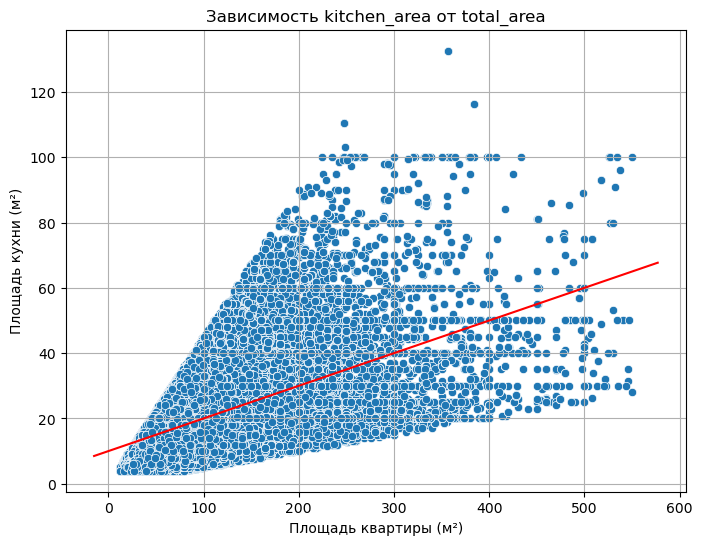

In [96]:
#построим точечный график
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='area', y='kitchen_area')
x_vals = np.array(plt.gca().get_xlim())
y_vals = 0.1 * x_vals + 10
plt.plot(x_vals, y_vals, color='red', label='y = 0.1x + 10')
plt.title('Зависимость kitchen_area от total_area')
plt.xlabel('Площадь квартиры (м²)')
plt.ylabel('Площадь кухни (м²)')
plt.grid(True)
plt.show()

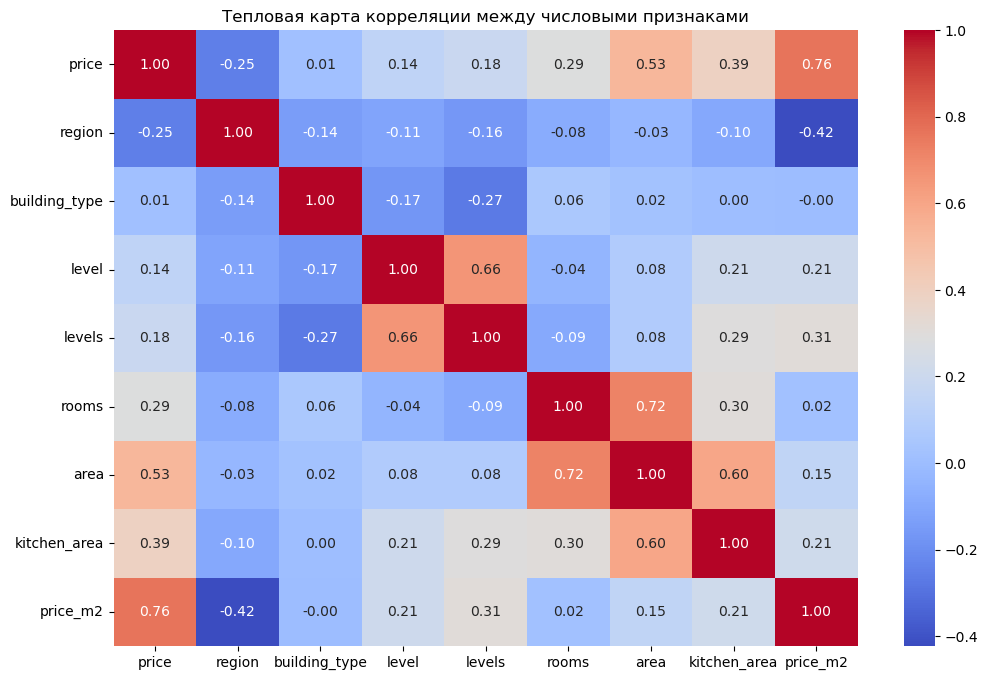

In [97]:
#построим матрицу корреляций
numeric_df = df.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Тепловая карта корреляции между числовыми признаками')
plt.show()


**Площадь кухни не имеет линейной зависимости от разных категорий или имеет очень слабую связь, даже с площадью квартиры коэффициент корреляции составляет 0.6, что недостаточно для модели множественной линейной регрессии**

**Т.к. у нас нет линейной зависимости попробуем заполнить пропуски моделью RandomForest, он хорошо справляется сданными, которые имеют сложные, нелинейные зависимости Данная модель нечувствительна к выбросам в данных (например большая кухня или слишком маленькая). Также алгоритм позволит нам предугадать цену на основе не только числовых признаков, но и категориальных. Random Forest хорошо масштабируется и может работать с подвыборками большого объёма данных.**

In [98]:
#проверка на наличие пропусков
print(f"Количество пропусков в kitchen_area: {df['kitchen_area'].isnull().sum()}")

#выбор подвыборки из данных с известным kitchen_area
df_train_sample = df[df['kitchen_area'].notnull()].sample(n=1000000, random_state=42)

#отделяем данные для предсказания (с пропусками)
df_predict = df[df['kitchen_area'].isnull()]

#указываем признаки для модели
features = ['area', 'rooms', 'levels', 'price']
X_train_sample = df_train_sample[features]
y_train_sample = df_train_sample['kitchen_area']

X_predict = df_predict[features]

#проверяем размер выборки
print(f"Размер обучающей выборки: {X_train_sample.shape[0]}")




Количество пропусков в kitchen_area: 241243
Размер обучающей выборки: 1000000


In [99]:
#разделяем на тренировочные и тестовые данные

X_train, X_test, y_train, y_test = train_test_split(
    X_train_sample, y_train_sample, test_size=0.2, random_state=42
)

#проверяем размер тренировочной и тестовой выборок
print(f"Размер X_train: {X_train.shape[0]}")
print(f"Размер X_test: {X_test.shape[0]}")



Размер X_train: 800000
Размер X_test: 200000


In [100]:
#создаем модель
model = RandomForestRegressor(
    n_estimators=100,        
    max_depth=10,         
    random_state=42,
    n_jobs=-1               
)

# Обучение модели
model.fit(X_train, y_train)
print("Модель успешно обучена.")



Модель успешно обучена.


In [101]:
#проверяем качество модели

#предсказания на тестовой выборке
y_pred = model.predict(X_test)

#метрики качества
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень из MSE (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")



Среднеквадратичная ошибка (MSE): 10.15
Корень из MSE (RMSE): 3.19
Коэффициент детерминации (R^2): 0.58


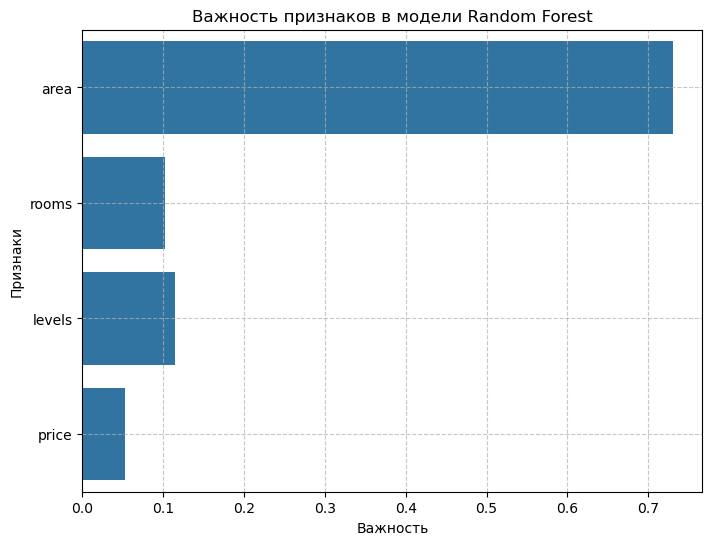

In [102]:
#анализируем важности признаков


importances = model.feature_importances_

plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=features)
plt.title('Важность признаков в модели Random Forest')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



In [103]:
#заполняем пропусков

#предсказание для пропусков
predicted_values = model.predict(X_predict)

#заполнение пропусков в kitchen_area
df.loc[df['kitchen_area'].isnull(), 'kitchen_area'] = predicted_values

#проверяем, что пропуски заполнены
print(f"Осталось пропусков в kitchen_area: {df['kitchen_area'].isnull().sum()}")

Осталось пропусков в kitchen_area: 0


<a id='42-вывод-4'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
    
## 4.2 Вывод по пункту 4
</div>

[Вернуться к содержанию](#задачи)

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

**Randomforest хорошо справился с поставленной задачей**
- RMSE: 3.19

    Для столбца с площадью кухни это приемлемая ошибка, но может быть значимой для небольших квартир. В целом ошибка удоговоримая
    
- Коэффициент детерминации (R²): 0.58
    
    Модель объясняет больше половины вариаций данных, что приемлемо для задачи с такой высокой вариативностью (площадь кухни может сильно различаться в зависимости от множества факторов)

- Наибольшую роль в прогнозировании площади кухни сыграли площадь квартиры и этажность здания

Random Forest показал умеренные результаты в заполнении пропусков
    
P.S. Модели можно было бы обучить и на категориальных признаках, там результат был еще лучше. Но перед финальным запуском работы модель никак не хотела грузиться, пришлось удалить категориальные признаки из обучения :(
</div>

<a id='5-выгода'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">5. Когда выгодно покупать/продавать объект недвижимости? </h1>
</div>

[Вернуться к содержанию](#задачи)

<a id='51-выгода-продажа-покупка'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 5.1 Анализ рынка недвижимости
</div>

[Вернуться к содержанию](#задачи)

**Построим несколько графиков, чтобы проанализировать рынок. Для начала посмотрим как изменялись цены по годам. Величина исследования - стоимость квартиры, т.к. это основная цифра при продаже или покупке квартиры**

In [104]:
df['year'] = df['date'].dt.year
df['year'].unique()

array([2018, 2019, 2020, 2021])

Данные представлены за 4 года, что позволит нам провести анализ рынка на большом куске времени

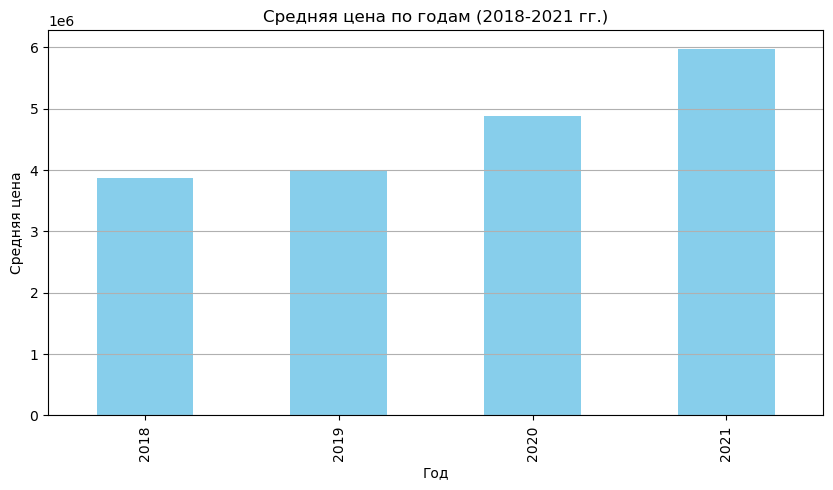

In [105]:
#считаем реднюю цену по годам и строим график
prices_by_year = df.groupby(df['year'])['price'].mean()


plt.figure(figsize=(10, 5))
prices_by_year.plot(kind='bar', color='skyblue', title='Средняя цена по годам (2018-2021 гг.)')
plt.xlabel('Год')
plt.ylabel('Средняя цена')
plt.grid(True, axis='y')
plt.show()

In [106]:
pd.options.display.float_format = '{:,.2f}'.format  #ставим формат чисел без сокращения с е+..
prices_by_year

year
2018   3,864,290.04
2019   4,003,399.27
2020   4,882,544.76
2021   5,981,844.61
Name: price, dtype: float64

**По графику видим, что цена за квартиру росла каждый год, что не удивительно. Рост цен - нормальное экономическое явление, т.к. растет спрос, растут цены на материалы, инфляция и др. факторы.**

**Рост цен был умеренным с 2018 по 2019 год, однако с 2019 по 2020 и с 2020 по 2021 года происходили резкие скачки цен. Этому есть несколько причин:**
- В апреле 2020 года были введены льготные ипотеки, из-за чего вырос спрос на новостройки. При этом предложение не успевало за растущим спросом, что вызвало дисбаланс на рынке. Застройщики, пользуясь ситуацией, подняли цены, а общие экономические условия (рост цен на материалы, низкие ставки ЦБ) усилили этот эффект
- Инфляция 4-6%
- Падение курса рубля
- Увеличение стоимости строительства почти на 25-35%

In [107]:
price_2018 = prices_by_year.get(2018, 0)  # Если 2018 отсутствует, вернётся 0
price_2021 = prices_by_year.get(2021, 0)
print(f'Разница в средней цене между 2021 и 2018 гг.: {(price_2021/price_2018):.2f}')

Разница в средней цене между 2021 и 2018 гг.: 1.55


**Разница в цене жилья выросла почти в полтора за 4 года или на 55%. А за последние 4 года рост цен на новостройки составил 113% по результатам анализа рынка Циан**

Далее посмотрим как цена зависит от месяца

In [108]:
#добавляем столбец с месяцем
df['month'] = df['date'].dt.month

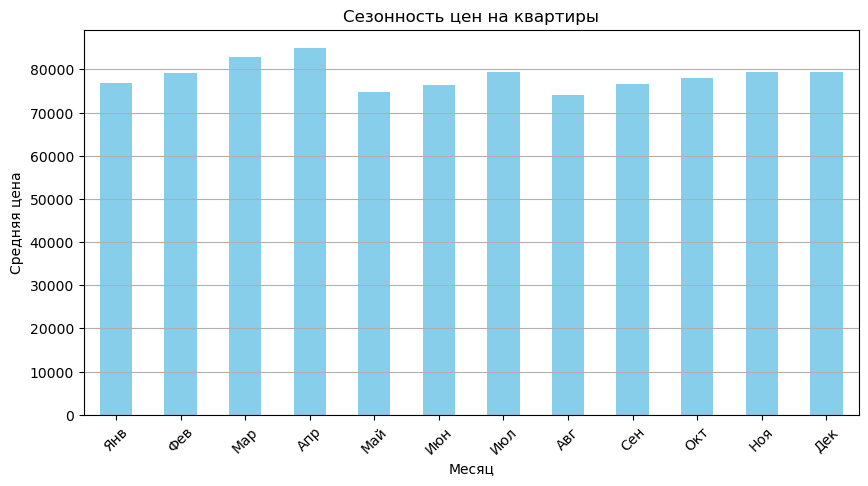

In [109]:
#средняя цена по месяцам за все годы
seasonality = df.groupby('month')['price_m2'].mean()

plt.figure(figsize=(10, 5))
seasonality.plot(kind='bar', color='skyblue', title='Сезонность цен на квартиры')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена')
plt.xticks(range(12), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'], rotation=45)
plt.grid(True, axis='y')
plt.show()


In [110]:
seasonality

month
1    76,886.32
2    79,127.26
3    82,792.66
4    84,911.85
5    74,798.50
6    76,283.64
7    79,408.50
8    74,154.63
9    76,547.35
10   77,902.56
11   79,320.87
12   79,303.49
Name: price_m2, dtype: float64

**В целом, цены находятся примерно на одном уровне и сильных различий по месяцам не имеют. Однако заметим по графику, что с сентября по май цены на квартиры растут (исключение январь) , а значит считаются благоприятным сезон для более выгодной продажи квартир. Такой период называется деловым сезоном, т.к. в это время обычно спрос превосходит предложение, что дает возможность продавцам повышать цены**

**А вот выгодными месяцами для покупки квартиры является период с мая по август и январь. Летом люди находятся в отпусках и временно откладывают свои дела, спрос замедляется. В Январе спрос снижают долгие праздники в начале месяца**

**За период с 2018-2021 гг. в среднем самыми выгодными месяцами оказались Апрель (4 857 653 тыс) и Август (4 112 691 тыс) для продажи и покупки соответственно**

В конце посмотрим на динамику цен по месяцам за 4 года

In [111]:
#добавляем столбец с месяцем и годом
df['year_month'] = df['date'].dt.to_period('M')

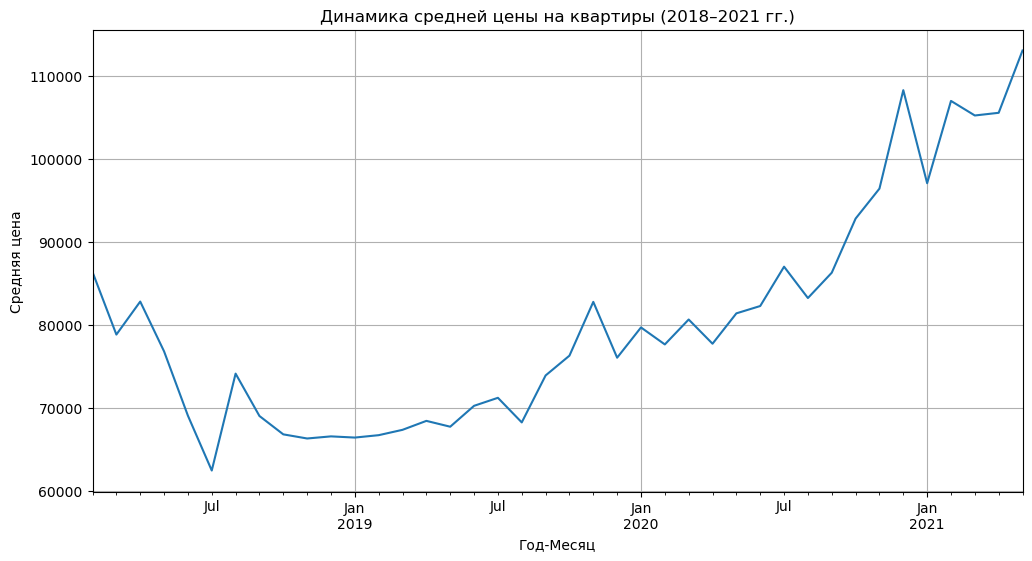

In [112]:
average_prices = df.groupby('year_month')['price_m2'].mean()

plt.figure(figsize=(12, 6))
average_prices.plot(title='Динамика средней цены на квартиры (2018–2021 гг.)')
plt.xlabel('Год-Месяц')
plt.ylabel('Средняя цена')
plt.grid(True)
plt.show()

**По графику видим, что в 2018 году был резкий спад цены в июле, но уже в августе цена снова поднялась. Далее стоимость квартир, хоть и с колебанием, стабильно растет. В 2021 году был резки скачок цен в декабре, но уже в января резко опустилась. последний зафиксированный максимум цены был в мае 2021 года.**

**Данная динамика подтверждает закономерность сезонности цен, которая была выявлена выше. Особенно это заметно на промежутке 2018-2020гг. А вот до 2021 года цены почти всегда росли вне зависимости от месяца, что объясняется вышеупомянутыми причинами**

<a id='52-вывод-5'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 5.2 Вывод по пункту 5
</div>

[Вернуться к содержанию](#задачи)

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

**Рынок недвижимости 2018-2021 гг. был проанализирован на тему выгоды покупки/продажи квартиры. Были получены следующие результаты:**
- Цены на квартиры растут каждый год по многим причинам (инфляция, льготные ипотеки, спрос и т.д.)
- Наблюдается сезонность продаж/покупок, хоть и незначительная
- Динамика роста цен подверждает сезонность продажи/покупки квартиры, но также подвержена влиянию внешних факторов
</div>

<a id='6-признаки'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">6. Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности </h1>
</div>

[Вернуться к содержанию](#задачи)

**Чтобы найти зависимость между стоимостью и другими признаками, нужно посмотреть на нормальность распределения, чтобы дальше определить план действий**

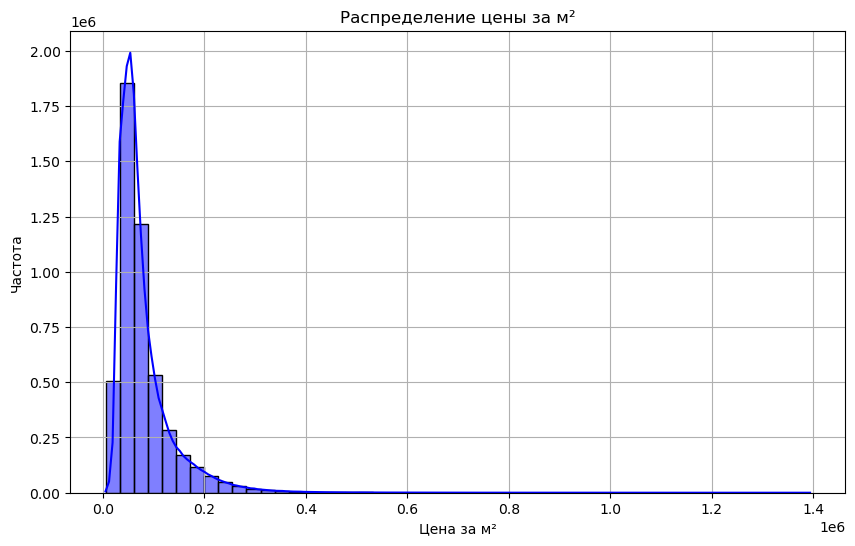

In [113]:
#гистограмма для проверки распределения
plt.figure(figsize=(10, 6))
sns.histplot(df['price_m2'], bins=50, kde=True, color='blue')
plt.title('Распределение цены за м²')
plt.xlabel('Цена за м²')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [114]:
#проверка на нормальность
stat, p_value = normaltest(df['price_m2'])
print(f"Тест нормальности D’Agostino: Статистика = {stat:.2f}, p-значение = {p_value:.4f}")

#асимметрия и эксцесс
skewness = skew(df['price_m2'])
kurt = kurtosis(df['price_m2'])

print(f"Асимметрия: {skewness:.2f}")
print(f"Эксцесс: {kurt:.2f}")

Тест нормальности D’Agostino: Статистика = 4198340.61, p-значение = 0.0000
Асимметрия: 3.86
Эксцесс: 32.89


**График и тест показали нам, что цена не имеет нормального распределения. Ассиметриия (3,86>1) указывает на сильно скошенное распределение, а эксцесс больше 0 указала на остроконечное распределение.**

<a id='61-категории'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 6.1 Зависимость стоимости объекта от категориальных признаков
</div>

[Вернуться к содержанию](#задачи)

**Для определения зависимости стоимости жильня от категориальных признаком будем использовать тест Крускала-Уоллиса. Он может работать с ненормальным распределением и менее подвержен влиянию выбросов (как например ANOVA), а также работает с большим кол-вом групп. Работает данный тест с рангами. Рассчитывает, насколько ранги данных в одной группе отличаются от рангов в других группах (ранги присваиваются данным после сортировки по возрастанию). Если распределение рангов между группами существенно отличается, тест выдаёт значительное p-значение.**

Гипотезы:
- H0: Все группы имеют одинаковое распределение (ранги не отличаются)
- H1: Как минимум одна из групп имеет распределение, отличное от других

In [115]:
categorical_features = ['reg_name', 'building_type', 'object_type']

#тест Крускала-Уоллиса для категориальных признаков
for feature in categorical_features:
    groups = [df[df[feature] == category]['price_m2'] for category in df[feature].unique()]
    stat, p_value = kruskal(*groups)
    print(f"Тест Крускала-Уоллиса для {feature}: Статистика = {stat:.2f}, p-значение = {p_value:.4f}")

    if p_value < 0.05:
        print(f"{feature} оказывает значимое влияние на price_m2.")
    else:
        print(f"{feature} не оказывает значимого влияния на price_m2.")


Тест Крускала-Уоллиса для reg_name: Статистика = 2619856.84, p-значение = 0.0000
reg_name оказывает значимое влияние на price_m2.
Тест Крускала-Уоллиса для building_type: Статистика = 729220.38, p-значение = 0.0000
building_type оказывает значимое влияние на price_m2.
Тест Крускала-Уоллиса для object_type: Статистика = 7423.11, p-значение = 0.0000
object_type оказывает значимое влияние на price_m2.


**Тест показал, что все категориальные перменные оказывают значительное влияние на стоимость м2. Статистика по 3 категориям высокая. Стоимость м2 сильно отличается в зависимости от региона, в котором находится квартира, также цена зависит и от типа здания, но в меньшей степени. Тип объекта также влияет на стоимость. Ожидаемо оказывает самое сильное влияние, так как цены на недвижимость сильно зависят от географии. Например, цены в Москве и регионах могут отличаться в разы.**

**P-значение везде нулевое, что указывает на очень высокую значимость категорий. Нулевое значение не является ошибкой. особенно учитывая большое количество данных. Но проверим на более маленькой выборке.**

In [116]:
sampled_df = df.sample(n=3000, random_state=42)
stat, p_value = kruskal(*[sampled_df[sampled_df['reg_name'] == r]['price_m2'] for r in sampled_df['reg_name'].unique()])
print(f"Тест на подвыборке: Статистика = {stat:.2f}, p-значение = {p_value:.4f}")

Тест на подвыборке: Статистика = 1683.33, p-значение = 0.0000


**Маленькая выборка также указывает на сильное влияние категориальных значений на цену м2. Можем смело отвергать нулевую гипотезу**

**Проверим также практическую значимость. Даже если различия статистически значимы, нужно проверить, имеют ли они реальное значение. Построим графики медиан**

C:\Users\Admin\AppData\Local\Temp\ipykernel_7412\1510691882.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


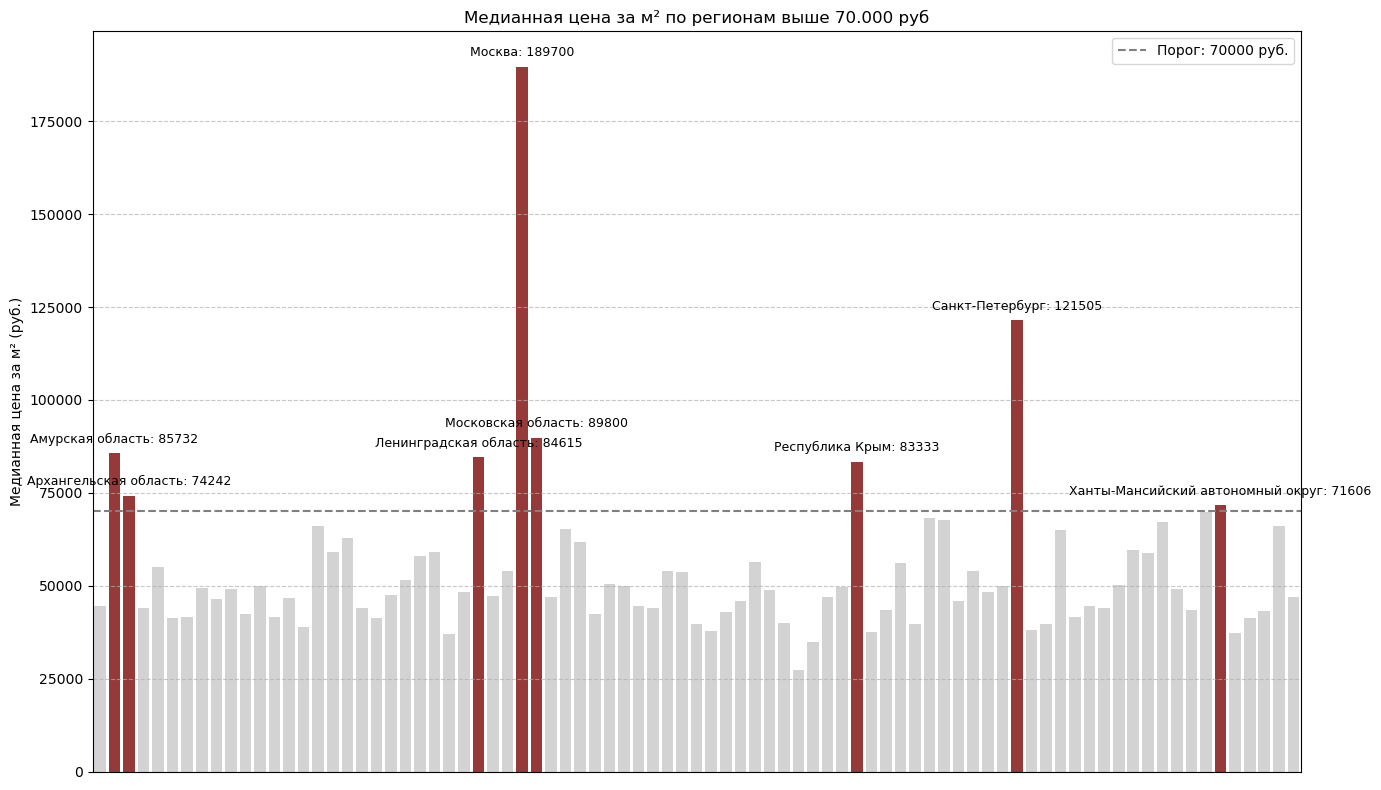

In [117]:
#посмотрим на медианные значения по регионам, посмотрим лидеров

def plot_regions_above_threshold(df, threshold=70000):
    
    #рассчитываем медиану цены для каждого региона
    region_medians = df.groupby('reg_name')['price_m2'].median()

    #определяем регионы выше и ниже порога
    regions_above_threshold = region_medians[region_medians > threshold]
    regions_below_threshold = region_medians[region_medians <= threshold]

    #строим диаграммы
    plt.figure(figsize=(14, 8))
    bars = sns.barplot(
        x=region_medians.index, 
        y=region_medians.values, 
        palette=['brown' if region in regions_above_threshold.index else 'lightgrey' for region in region_medians.index]
    )

    #подписи только регионов выше порога для наглядности
    for region, value in regions_above_threshold.items():
        plt.text(region_medians.index.get_loc(region), value + 2000, f"{region}: {value:.0f}",
                 color='black', ha='center', va='bottom', fontsize=9)

    #настройка графика
    plt.axhline(threshold, color='grey', linestyle='--', label=f'Порог: {threshold} руб.')
    plt.title('Медианная цена за м² по регионам выше 70.000 руб')
    plt.xlabel('')
    plt.ylabel('Медианная цена за м² (руб.)')
    plt.legend()
    plt.xticks([])  #убираем подписи на оси X
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_regions_above_threshold(df, threshold=70000)

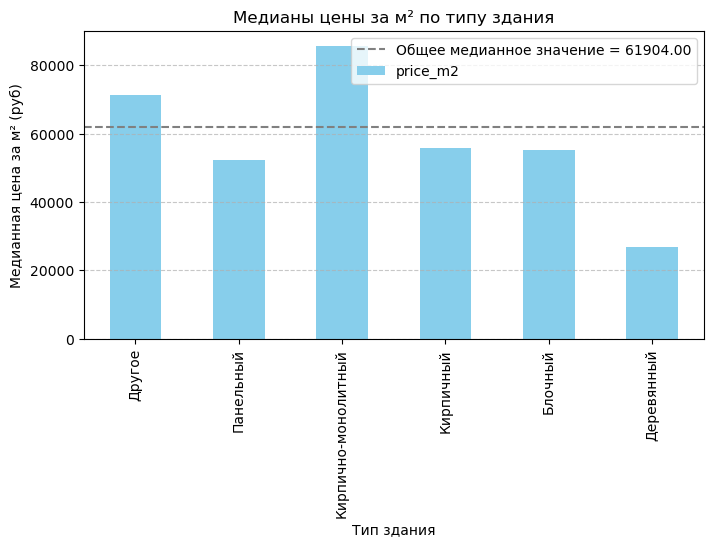

In [118]:
building_type_medians = df.groupby('building_type')['price_m2'].median()
building_type_medians.index = building_type_medians.index.map({0: 'Другое', 1: 'Панельный', 2: 'Кирпично-монолитный', 3: 'Кирпичный', 4: 'Блочный', 5: 'Деревянный'})
overall_median = df['price_m2'].median()

plt.figure(figsize=(8, 4))
building_type_medians.plot(kind='bar', color='skyblue')
plt.axhline(overall_median, color='grey', linestyle='--', label=f'Общее медианное значение = {overall_median:.2f}')
plt.title('Медианы цены за м² по типу здания')
plt.legend()
plt.xlabel('Тип здания')
plt.ylabel('Медианная цена за м² (руб)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

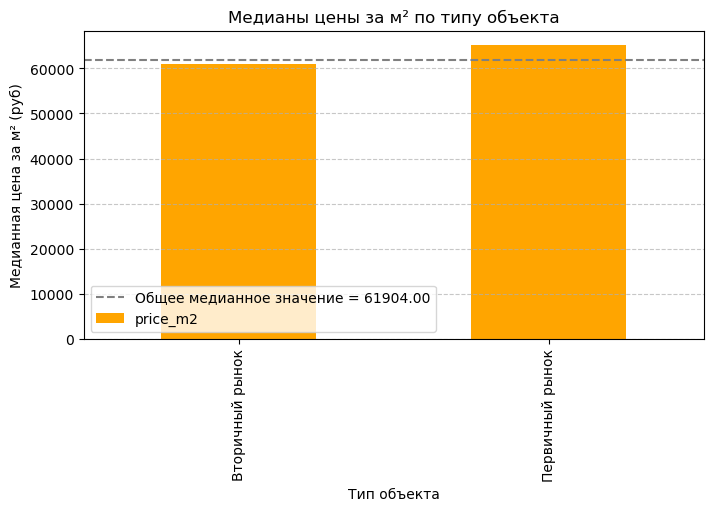

In [119]:
object_type_medians = df.groupby('object_type')['price_m2'].median()
object_type_medians.index = object_type_medians.index.map({True: 'Первичный рынок', False: 'Вторичный рынок'})

plt.figure(figsize=(8, 4))
object_type_medians.plot(kind='bar', color='orange')
plt.axhline(overall_median, color='grey', linestyle='--', label=f'Общее медианное значение = {overall_median:.2f}')
plt.title('Медианы цены за м² по типу объекта')
plt.legend()
plt.xlabel('Тип объекта')
plt.ylabel('Медианная цена за м² (руб)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Медианный значения показали, что регион и тип здания практически значимы для цены м2, а значит важны для реальной жизни. А вот тип рынка сильной практической значимостью не обладает, хоть и значим статистически.**

**Многие регионы имеют медианную цену за м2 выше общего медианного значения (65тыс). В лидерах Москва, Санкт-Петербург, Московская и Ленинградская области, Амурская область, Республика Крым и др. Первые 4 региона традиционно из года в год являются самыми дорогими землями для покупки жилья. Большой спрос, высокая плотность населения, дорогая земля, высокие цены на строительство, хорошая инфраструктура и др факторы оказывают сильное воздействие на рост цен. Высокую цену в Амурской области аналитики часто объясняют близостью к Китаю и рынком, который на 80% состоит из ипотеки. Республика Крым привлекает людей курортной недвижимостью, поднимая ценник за вид на море, морской воздух и т.п. Большинство покупателей недвижимости в Крыму имеют зарплаты в среднем больше, чем в самом регионе, что повышает цены на недвижимость.**

**Самые высокие цены наблюдаются в кирпично-монолитных и других (монолитный железобетон, сталь) типов домах. Это связано с тем, что большинство домой сейчас строятся именно из этих материалов. С каждым годом все больше появляется именно высотных жилых домов, которые могут находиться в хороших районах + наличие льготной ипотики на новостройки, увеличивает спрос на данный рынок**

**На Первичный рынок спрос выше, хоть и незначительно. Обладать своим жильем уже престижно и дорого, внезависимости от типа рынка**

<a id='62-числа'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 6.2 Зависимость стоимости объекта от числовых признаков
</div>

[Вернуться к содержанию](#задачи)

**Для определения значимости числовах признаков сначала посмотрим имеют ли они линейное распредееление. Не имеют (на основе графиков). Проведем тест Спирмена, т.к. он не требует нормального распределения и учитывает монотонные (линейные или нелинейные) зависимости.**

Гипотезы:

- H0: Между переменными отсутствует монотонная зависимость (никакая связь — ни линейная, ни нелинейная — не выражена)
- H1: Между переменными существует монотонная зависимость (положительная или отрицательная)

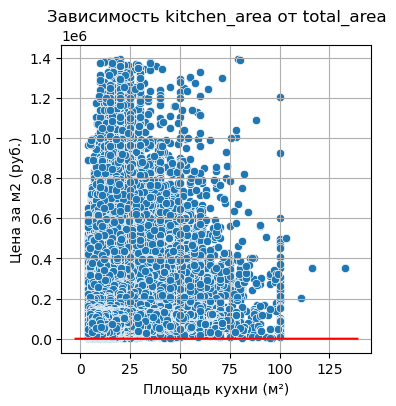

In [120]:
#построим точечный график
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, y='price_m2', x='kitchen_area')
x_vals = np.array(plt.gca().get_xlim())
y_vals = 0.1 * x_vals + 10
plt.plot(x_vals, y_vals, color='red', label='y = 0.1x + 10')
plt.title('Зависимость kitchen_area от total_area')
plt.xlabel('Площадь кухни (м²)')
plt.ylabel('Цена за м2 (руб.)')
plt.grid(True)
plt.show()

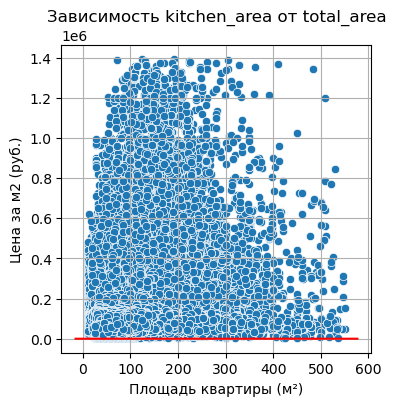

In [121]:
#построим точечный график
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, y='price_m2', x='area')
x_vals = np.array(plt.gca().get_xlim())
y_vals = 0.1 * x_vals + 10
plt.plot(x_vals, y_vals, color='red', label='y = 0.1x + 10')
plt.title('Зависимость kitchen_area от total_area')
plt.xlabel('Площадь квартиры (м²)')
plt.ylabel('Цена за м2 (руб.)')
plt.grid(True)
plt.show()

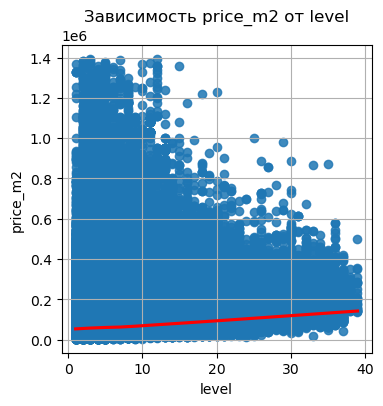

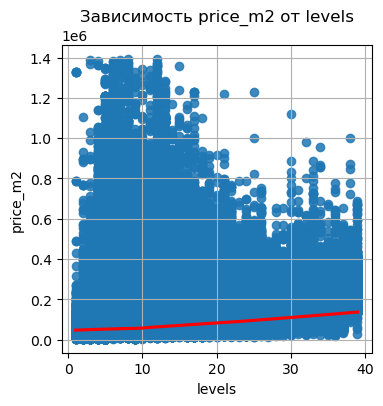

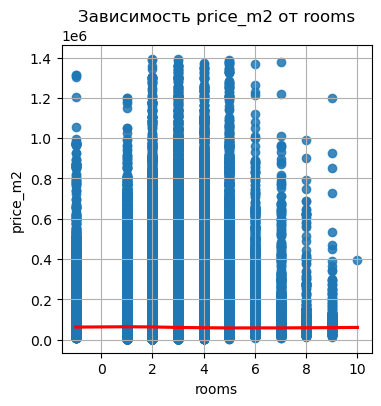

In [122]:
#визуализация остальных зависимостей (площади отдельно, т.к. они никак не хотели грузиться :))
for feature in ['level', 'levels', 'rooms']:
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=df[feature], y=df['price_m2'], alpha=0.3)
    sns.regplot(x=df[feature], y=df['price_m2'], lowess=True, line_kws={"color": "red"})
    plt.title(f'Зависимость price_m2 от {feature}')
    plt.xlabel(feature)
    plt.ylabel('price_m2')
    plt.grid(True)
    plt.show()


In [148]:
#загружаем данные в Dask DataFrame
dask_df = dd.from_pandas(df, npartitions=10)  #библиотека, которая позволяет обрабатывать данные частями и ускоряет код

#функция для расчета корреляции Спирмена
def compute_spearman_corr(feature):
    #преобразуем колонки в pandas Series для использования в scipy
    feature_series = dask_df[feature].compute()
    target_series = dask_df['price_m2'].compute()
    
    #вычисляем корреляцию Спирмена
    spearman_corr, p_value = spearmanr(feature_series, target_series)
    return feature, spearman_corr, p_value

#выбираем числовые признаки
numeric_features = ['level', 'levels', 'rooms', 'area', 'kitchen_area']

#расчитываем корреляцию для всех числовых признаков
results = [compute_spearman_corr(feature) for feature in numeric_features]

#формируем таблицу с результатами
correlation_results = pd.DataFrame(results, columns=['Feature', 'Spearman Correlation', 'p-value'])
correlation_results

,Feature,Spearman Correlation,p-value
0,level,0.25,0.00
1,levels,0.38,0.00
2,rooms,-0.02,0.00
3,area,0.02,0.00
4,kitchen_area,0.20,0.00


***ВЫВОД ПО СПИРМЕНУ***

Значения от -1 до 1:
- Близкие к 1: сильная положительная монотонная зависимость. (стоимость и признак растут)
- Близкие к -1: сильная отрицательная монотонная зависимость. (стоимость растет, признак уменьшается)
- Близкие к 0: зависимость отсутствует.

1. Умеренные зависимости (level, levels, kitchen_area):

Эти признаки оказывают влияние на цену за квадратный метр, но не являются основными определяющими факторами.
Например, этажность здания может быть более важной, чем уровень отдельного этажа.

2. Слабые или отсутствующие зависимости (rooms, area):

Эти признаки оказывают минимальное влияние на цену за квадратный метр.
Возможно, общая стоимость квартиры больше зависит от этих факторов, чем цена за м².

3. P-value = 0.00 для всех признаков:

Это говорит о том, что зависимости статистически значимы. Однако практическая значимость слабых зависимостей (например, для rooms и area) может быть минимальной.

**Проверим зависимость еще одним коэффициентом корреляции Кендалом. Он подходит для большого набора данных, устойчив к шумам и выбросам, а также оценивает силу и направленность монотонной связи**

In [146]:
numeric_features = ['level', 'levels', 'rooms', 'area', 'kitchen_area']
results = []

for feature in numeric_features:
    tau, p_value = kendalltau(df[feature], df['price_m2'])
    results.append({'Feature': feature, 'Kendall Tau': tau, 'p-value': p_value})

#формируем таблицу с результатами
kendall_results = pd.DataFrame(results)
kendall_results

,Feature,Kendall Tau,p-value
0,level,0.18,0.00
1,levels,0.27,0.00
2,rooms,-0.02,0.00
3,area,0.01,0.00
4,kitchen_area,0.14,0.00


***ВЫВОД ПО КЕНДАЛУ***

**Коэф-т Кендала подвердил результаты Спирмена, показав примерно те же результаты (трактуются также как и по Спирмену). Связь хоть и слабая, но значимая, на это указывает p-значение. Такая ситуация связана с тем, что у нас много данных**

**На основе данных, полученных тестами мы отвергаем нулевую гипотезу об отсутствии зависимости между переменными**

<a id='63-скрытые-закономерности'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 6.3 Поиск скрытых закономерностей
</div>

[Вернуться к содержанию](#задачи)

**Некоторые скрытые закономерности были найдены в других пунктах, например сезонность продажи и покупки. Проверим еще несколько закономерностей:**

- Цена за всю квартиру зависит от площади и площади кухни зависит больше, чем цена за м2
- Цена изменяется в зависимости от этажа, на котором находится квартира
- Цена растет, если в квартире большая кухня

In [147]:
#функция для расчета корреляции Спирмена
def compute_spearman_corr(feature):
    #преобразуем колонки в pandas Series для использования в scipy
    feature_series = dask_df[feature].compute()
    target_series = dask_df['price'].compute()
    
    #вычисляем корреляцию Спирмена
    spearman_corr, p_value = spearmanr(feature_series, target_series)
    return feature, spearman_corr, p_value

#выбираем числовые признаки
numeric_features = ['area', 'kitchen_area']

#расчитываем корреляцию для всех числовых признаков
results = [compute_spearman_corr(feature) for feature in numeric_features]

#формируем таблицу с результатами
correlation_results = pd.DataFrame(results, columns=['Feature', 'Spearman Correlation', 'p-value'])
correlation_results

,Feature,Spearman Correlation,p-value
0,area,0.53,0.00
1,kitchen_area,0.46,0.00


**Скрытая закономерность подвердилась! Площадь действительно больше влияет на общую цену, чем на цену за м2. Причем это различие довольно большое (площадь квартиры: 0.53 > 0.01, площадь кухни: 0.46 > 0.14). Нулевую гипотезу отвергаем**

Гипотезы:

- H0: Между переменными отсутствует монотонная зависимость (никакая связь — ни линейная, ни нелинейная — не выражена)
- H1: Между переменными существует монотонная зависимость (положительная или отрицательная)

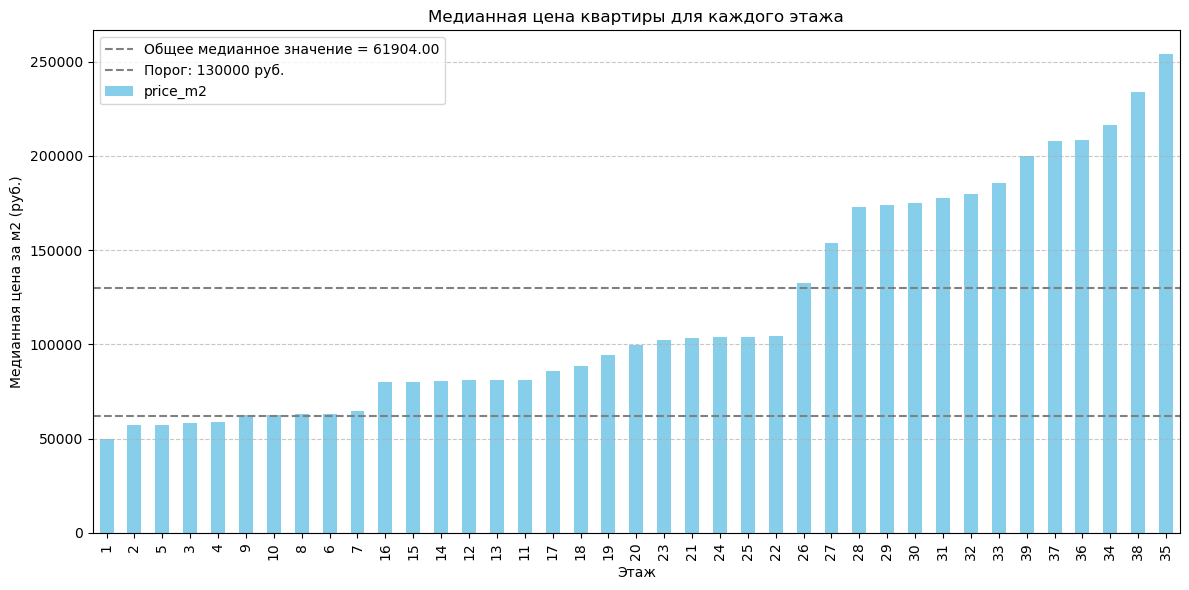

In [126]:
#рассчитаем медианные значения цены для каждого этажа
median_price_per_floor = df.groupby('level')['price_m2'].median().sort_values()
overall_median = df['price_m2'].median()

# Построим график
plt.figure(figsize=(12, 6))
median_price_per_floor.plot(kind='bar', color='skyblue')
plt.axhline(overall_median, color='grey', linestyle='--', label=f'Общее медианное значение = {overall_median:.2f}')
plt.axhline(130000, color='grey', linestyle='--', label=f'Порог: 130000 руб.')
plt.title('Медианная цена квартиры для каждого этажа')
plt.legend()
plt.xlabel('Этаж')
plt.ylabel('Медианная цена за м2 (руб.)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Цена действительно зависит от высоты этажа. Предпочтительные этажи (выше медианы 61904 тыс) начинаются с 11 и заканчиваются 39. Люди выбирают квартиры на более высоких этажах т.к. там лучше вид, лучше естественное ощущение, не доходит шум с улицы. Наименее популярным является 1 этаж, тому служит ряд причин: шум, мало света, отсутствие балкона, пыль, сырость из подвала. Наиболее предпочтительный 35 этаж**

In [127]:
#создадим группы на основе квантилей площади кухни
df['kitchen_group'] = pd.qcut(df['kitchen_area'], q=[0, 0.25, 0.75, 1], labels=['Ниже 25%', '25-75%', 'Выше 75%'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_7412\2496441277.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_price_by_group = df.groupby('kitchen_group')['price_m2'].median()


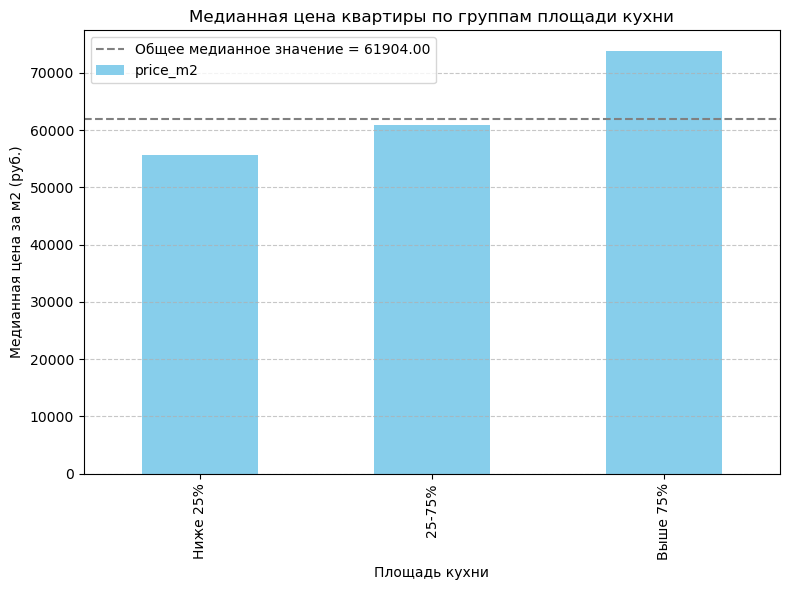

In [128]:
#рассчитываем медианное значение цены для каждой группы
median_price_by_group = df.groupby('kitchen_group')['price_m2'].median()

plt.figure(figsize=(8, 6))
median_price_by_group.plot(kind='bar', color='skyblue')
plt.axhline(overall_median, color='grey', linestyle='--', label=f'Общее медианное значение = {overall_median:.2f}')
plt.title('Медианная цена квартиры по группам площади кухни')
plt.legend()
plt.xlabel('Площадь кухни')
plt.ylabel('Медианная цена за м2 (руб.)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Площадь кухни действительно влияет на стоимость за м2: чем больше площадь кухни, тем больше стоимость. Квартиры с большими кухнями, скорее всего, являются премиальным жильем. Хоть мы и доказывали значимость зависимости цены от площади кухни, на графике это выглядит более наглядно. Также мы получили подверждение, что несмотря на то, что коэф-т корреляции Спирмена довольно низкий (0.20), зависимость все равно остается статистически значимой.**

<a id='64-вывод-6'></a>

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 6.4 Вывод по пункту 6
</div>

[Вернуться к содержанию](#задачи)

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

**Стоимость за м2 действительно зависит от множества факторов. Большему воздействию она подвержена со стороны категориальных принзаков. Самое большое влияние оказывает регион, в котором находится квартира, что не удивительно. В разных регионах разный уровень жизни, уровень дозода и плотность населения. Все это влияет на спрос и предложение, соответственно и на цену.**
    
**Числовые признаки тоже играют важную роль в составлении цены. По итогам тестов мы узнали, что цена за м2 наиболее зависима от этажности здания и этажа, на котором находится квартира (в новостройках цена за м2 выше чем в более низких зданиях вторичного рынка). А вот от площади квартиры и площади кухни больше зависит общая цена. При увеличении площади общая стоимость растёт линейно, в то время как цена за м² может оставаться стабильной или снижаться. В больших квартирах цена за м² часто ниже, чем в маленьких, из-за эффекта экономии масштаба: маленькие квартиры продаются дороже за м² из-за более высокого спроса среди покупателей с ограниченным бюджетом. Квартиры с большими кухнями часто относятся к более высокому ценовому сегменту, что увеличивает их общую стоимость. Однако влияние площади кухни на цену за м² слабеет, так как площадь кухни является лишь частью общей площади квартиры. Квартира с кухней 40 м² в доме премиум-класса может стоить в два раза больше квартиры с кухней 10 м², но цена за м² в премиальной квартире не обязательно будет вдвое выше. Цена за м² более стабильна, так как её изменения зависят от рыночных факторов (например, спрос, регион, премиальность жилья)**
</div>

<a id='7-своя-гипотеза'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">7. Выдвинете и проверьте собственную гипотезу статистическими методами </h1>
</div>

[Вернуться к содержанию](#задачи)

<a id='71-бутстрэп'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
    
## 7.1 Бутстрапирование
</div>

[Вернуться к содержанию](#задачи)

**Мы уже выяснили, что на цену за квартиру и цену за м2 влияют разные факторы. Стало интересно, влияет ли просторность на цену за м2, данную гипотезу и проверим. Определять просторность квартиры будем определять как отношение общей площади к количеству комнат**

Гипотезы:
- Н0: Цена за м2 не зависит от просторности (разница в цене между просторными и непросторными квартирами случайна)
- Н1: Цена за м2 зависит от просторности и она статистически значима

In [129]:
#определяем среднюю площадь на комнату
df['space_room'] = df['area']/df['rooms']

In [130]:
#создадим столбец, разделяя комнаты на группы
conditions = [
    df['rooms'].isin([-1, 1, 2]),
    df['rooms'].isin([3, 4, 5]),
    df['rooms'] >= 6
]

choices = ['0-2 комнаты', '3-5 комнат', '+6 комнат']

df['room_group'] = np.select(conditions, choices)

**Бутстрапирование - это метод повторной выборки, который используется для оценки статистических характеристик данных, таких как среднее, медиана или доверительные интервалы. Он особенно полезен в контексте анализа недвижимости и проверки гипотез, когда данные не соответствуют стандартным предположениям, например, нормальному распределению. Вместо предположений о распределении бутстрап использует эмпирическое распределение, основанное на самих данных. Это позволяет учитывать все особенности, такие как выбросы или разреженные данные в некоторых группах. Будем проводить анализ именно на медиане, т.к. она сгладит влияние выбросов и мы получим более устойчивую оценку центральной тенденции.**

**Такой метод хорошо подходит для больших данных, т.к. он использует повторное выборочное моделирование. Также просторность - метрика, которая не всегда имеет чёткую границу, поэтому статистические тесты могут быть недостаточно точными из-за сложной структуры данных. Вместо строгого использования p-value, бутстрап предлагает интерпретацию через доверительные интервалы, что более интуитивно и гибко.**

**Будем сравнивать доверительные интервалы просторности и непросторность для трех групп квартир, если они не перекрываются (диапазоны не имеют общих значений), это указывает на статистически значимое изменение. Если перекрываются, изменения могут быть незначительными.**

In [131]:
#порог просторности поставим равные 0.75 квантилю
space_threshold = df['space_room'].quantile(0.75)
df['high_space'] = (df['space_room'] > space_threshold).astype(int)

In [132]:
high_space = df[df['high_space'] == 1]['price_m2']
low_space = df[df['high_space'] == 0]['price_m2']

In [133]:
n_iterations = 1000  #количество повторений бутстрэпа
room_groups = df['room_group'].unique()

results = []

#проходим по каждой группе количества комнат
for group in room_groups:
    #фильтруем данные для текущей группы
    group_df = df[df['room_group'] == group]
    
    #делаем разделение по просторности, где high_space = 1 и high_space = 0
    high_space_df = group_df[group_df['high_space'] == 1]['price_m2'].dropna()
    low_space_df = group_df[group_df['high_space'] == 0]['price_m2'].dropna()

    #делаем выборки и считаем медианные значения
    boot_medians_high = [np.median(np.random.choice(high_space_df, size=len(high_space_df), replace=True)) for _ in range(n_iterations)]
    boot_medians_low = [np.median(np.random.choice(low_space_df, size=len(low_space_df), replace=True)) for _ in range(n_iterations)]

    #доверительные интервалы (95%)
    ci_high = (np.percentile(boot_medians_high, 2.5), np.percentile(boot_medians_high, 97.5))
    ci_low = (np.percentile(boot_medians_low, 2.5), np.percentile(boot_medians_low, 97.5))
    
    #делаем столбцы, содержащие все выбранные средние значения по каждой категории, они понадобятся для построения графиков    
    high_median = [np.median(np.random.choice(high_space_df, size=len(high_space_df), replace=True)) for _ in range(n_iterations)]
    low_median = [np.median(np.random.choice(low_space_df, size=len(low_space_df), replace=True)) for _ in range(n_iterations)]

    #добавляем результаты в список
    results.append({
        'Группа': group,
        'Медиана (просторные)': np.median(high_space_df),
        'Медиана (непросторные)': np.median(low_space_df),
        '95% ДИ (просторные)': ci_high,
        '95% ДИ (непросторные)': ci_low,
        'Бутстрэп медиана (просторные)': np.median(boot_medians_high),
        'Бутстрэп медиана (непросторные)': np.median(boot_medians_low),
        'Выборка (просторные)': high_median,
        'Выборка (непросторные)': low_median
    })

In [134]:
bootstrap_results_df = pd.DataFrame(results)
bootstrap_results_df['Разница (просторные - непросторные)'] = bootstrap_results_df['Бутстрэп медиана (просторные)'] - bootstrap_results_df['Бутстрэп медиана (непросторные)']
bootstrap_results_df

,Группа,Медиана (просторные),Медиана (непросторные),95% ДИ (просторные),95% ДИ (непросторные),Бутстрэп медиана (просторные),Бутстрэп медиана (непросторные),Выборка (просторные),Выборка (непросторные),Разница (просторные - непросторные)
0,3-5 комнат,"88,461.00","58,412.00","(87861.8625, 89169.5125)","(58333.0, 58461.225)","88,461.00","58,413.25","[88000.0, 89092.0, 88888.0, 88122.0, 88000.0, ...","[58450.0, 58402.0, 58409.0, 58430.0, 58440.0, ...","30,047.75"
1,0-2 комнаты,"64,556.00","61,702.00","(64473.0, 64634.0)","(61666.0, 61764.0)","64,556.00","61,700.00","[64583.0, 64634.0, 64485.0, 64583.0, 64634.0, ...","[61666.0, 61702.0, 61724.0, 61702.0, 61666.0, ...","2,856.00"
2,+6 комнат,"166,651.00","98,297.50","(150000.0, 184998.0)","(95662.525, 100000.0)","167,335.50","98,246.00","[150366.0, 158745.0, 173070.0, 161813.5, 16479...","[96774.0, 96477.5, 97189.5, 95735.5, 99472.5, ...","69,089.50"


**По итогам бутстрапа можно сделать следующий вывод:**

- Разница между буст медианным значениями более точная метрика для оценки влияния просторности на ценму за м2, так как бутстрап медианы учитывают изменчивость данных лучше чем обычные медианы. Но они не сильно отличаются от изначальных медиан. Медианное значение для просторных квартир выше по всем трем группам. Наиболее сильная разница прослеживается для квартир, где комнат больше 5, где просторность очень ценится и такие квартиры продаются с наценкой. Наименьшая разница прослеживается для студий и 1- 2- шек, там просторность меньше влияет на цену за м2. 3-5 комнатные квартиры ценятся больше, если они просторнее

- Доверительные интвервалы нигде не перескаются, а значит просторность статистически значима, нулевая гипотеза отвергается

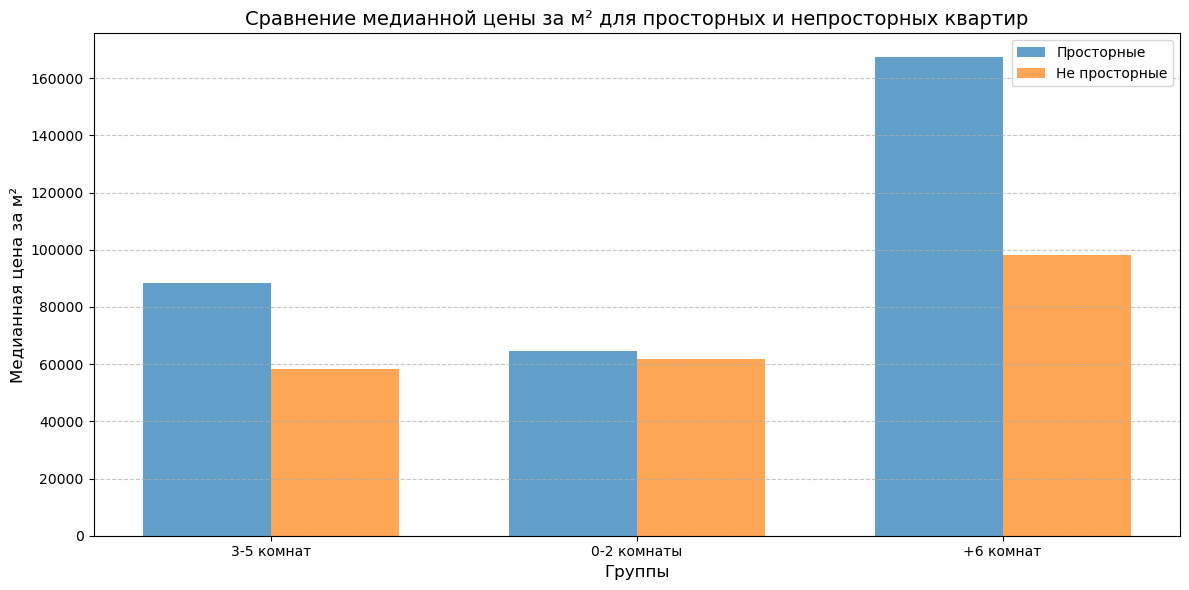

In [155]:
plt.figure(figsize=(12, 6))

bar_width = 0.35
index = range(len(bootstrap_results_df['Группа']))

#добавляем столбцы для просторных и непросторных
plt.bar(index, bootstrap_results_df['Бутстрэп медиана (просторные)'], bar_width, label='Просторные', alpha=0.7)
plt.bar([i + bar_width for i in index], bootstrap_results_df['Бутстрэп медиана (непросторные)'], bar_width, label='Не просторные', alpha=0.7)

plt.xlabel('Группы', fontsize=12)
plt.ylabel('Медианная цена за м²', fontsize=12)
plt.title('Сравнение медианной цены за м² для просторных и непросторных квартир', fontsize=14)
plt.xticks([i + bar_width / 2 for i in index],  bootstrap_results_df['Группа'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**С помощью графиков посмотрим на нормальность распределения. Построим графики до и после обновления по категориям параллельно для наглядности**

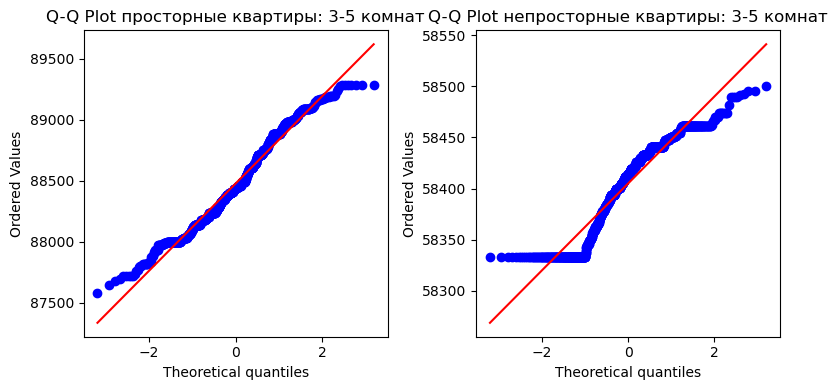

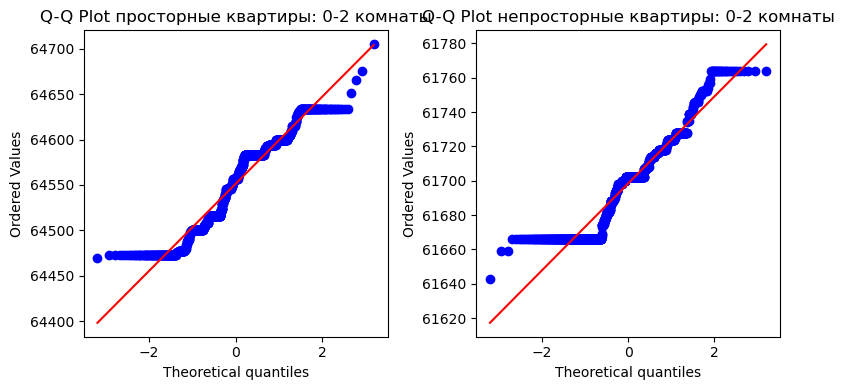

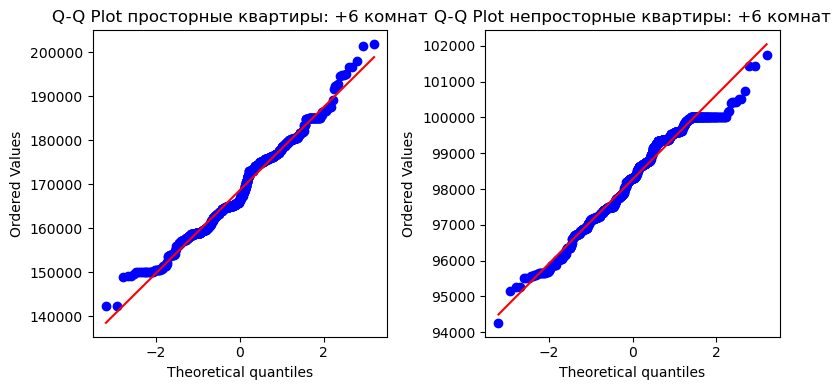

In [135]:
for i, column_boot in bootstrap_results_df.iterrows():
    group = column_boot['Группа']
    high_median = column_boot['Выборка (просторные)']
    low_median = column_boot['Выборка (непросторные)']

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    stats.probplot(high_median, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot просторные квартиры: {group}")

    plt.subplot(1, 2, 2)
    stats.probplot(low_median, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot непросторные квартиры: {group}")

    plt.tight_layout()
    plt.show()


**Распределение остается не нормальным. Хотя мы уже доказали значимость просторности к вкартирах с помощью доверительных интервалов, попробуем провести тест Манна-Уитни для подверждения результата. Выборки у нас не зависимы и включают в себя 1000 значений, тест должен справиться**

In [136]:
#проведем тест Манна-Уитни
alpha = 0.05

for _, row in bootstrap_results_df.iterrows():
    high_median = row['Выборка (просторные)']
    lpw_median = row['Выборка (непросторные)']
    
    stat, p_value = mannwhitneyu(high_median, low_median, alternative='two-sided')
    
    print(f"Группа: {row['Группа']}")
    print(f"Статистика: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value < alpha:
        print("Различия между просторными и непросторными квартирами статистически значимы. Отвергаем нулевую гипотезу.")
    else:
        print("Различия между просторными и непросторными квартирами статистически незначимы. Принимаем нулевую гипотезу.")
    print()


Группа: 3-5 комнат
Статистика: 0.0000, p-value: 0.0000
Различия между просторными и непросторными квартирами статистически значимы. Отвергаем нулевую гипотезу.

Группа: 0-2 комнаты
Статистика: 0.0000, p-value: 0.0000
Различия между просторными и непросторными квартирами статистически значимы. Отвергаем нулевую гипотезу.

Группа: +6 комнат
Статистика: 1000000.0000, p-value: 0.0000
Различия между просторными и непросторными квартирами статистически значимы. Отвергаем нулевую гипотезу.



**Тест Манна-Уитни подвердил отвержение гипотезы**

<a id='72-вывод-7'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
    
## 7.2 Вывод по пункту 7
</div>

[Вернуться к содержанию](#задачи)

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

**Бутстрапирование отличный метод, который подходит нам для проверки значимости просторности квартиры. Мы отвергли нулевую гипотезу о статистической значимости различия между просторной и непросторной квартирой. Таким образом мои предположения подвердились. Люди готовы платить за просторные квартиры больше, особенно это проглядывается для квартир начиная с 3. Т.к. обычно такие квартиры берут семьями, а значит как минимум для 3 людей, где каждому важно иметь свое пространство. тест Манна-Уитни также подвердил отвержение нулевой гипотезы на основе выборки, которая была сделана бля бутстрэпа. Значит, можно сделать вывод, что просторность определяет премиальность жилья**
</div>

<a id='8-модель-прогноза'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">8. Создайте модель прогноза цены объекта недвижимости </h1>
</div>

[Вернуться к содержанию](#задачи)

<a id='81-модель'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 8.1 Модель прогноза
</div>

[Вернуться к содержанию](#задачи)

**Вновь воспользуемся RandomForest**

In [137]:
sample_size = 100000

date_col = 'date' 
target = 'price_m2' #целевая переменная

In [138]:
#категориальные и числовые признаки
categorical_features = ['reg_name', 'building_type', 'object_type']
numerical_features = ['area', 'kitchen_area', 'rooms', 'level', 'levels', 'space_room']

#выделяем новые признаки
df['year'] = pd.to_datetime(df[date_col]).dt.year
df['month'] = pd.to_datetime(df[date_col]).dt.month
df['day_of_week'] = pd.to_datetime(df[date_col]).dt.dayofweek

#выбираем все признаки вместе
features = numerical_features + categorical_features + ['year', 'month', 'day_of_week']
df = df[features + [target]].dropna()

In [139]:
#создаём подвыборку
df_sample = df.sample(n=sample_size, random_state=42)

#разделяем данные на признаки (x) и целевую переменную (y)
X = df_sample[features]
y = df_sample[target]

#кодируем категориальные признаки
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

In [140]:
#разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#создание модели и ее обучение
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Модель успешно обучена.")

Модель успешно обучена.


In [141]:
#оцениваем модель
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Коэффициент детерминации (R²): {r2:.2f}")

Среднеквадратичная ошибка (MSE): 973490741.65
RMSE: 31200.81
Коэффициент детерминации (R²): 0.74


In [157]:
#важность признаков
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Признак': X.columns, 'Важность': importances})
feature_importances = feature_importances.sort_values(by='Важность', ascending=False)

feature_importances

,Признак,Важность
37,reg_name_Москва,0.43
70,reg_name_Санкт-Петербург,0.11
0,area,0.09
4,levels,0.07
5,space_room,0.06
...,...,...
25,reg_name_Камчатский край,0.00
41,reg_name_Новгородская область,0.00
36,reg_name_Магаданская область,0.00
48,reg_name_Приморский край,0.00


In [143]:
#пример прогноза
sample = X_test.iloc[0]  #пример объекта из тестовой выборки
predicted_price = model.predict([sample])[0]
print(f"Прогнозируемая цена: {predicted_price:.2f}")

Прогнозируемая цена: 85455.75


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<a id='82-вывод-8'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 8.2 Вывод по пункту 8
</div>

[Вернуться к содержанию](#задачи)

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

**R² = 0.74 указывает на хорошее качество модели. Это высокий показатель, указывающий на то, что большинство изменений в цене за м² можно объяснить выбранными признаками. Однако RMSE в 31200.81 рублей может быть значимым для некоторых сегментов рынка, особенно для регионов или квартир с низкой ценой за м², но все равно остается неплохим показателем. Высокое значение MSE (973490741.65) связано с масштабом данных, так как цены за м² измеряются в десятках тысяч**

**Высокое значение RMSE может быть связано с высокой вариативностью цен в исходных данных (например, элитные квартиры, регионы с высокой ценой)**

**Наиболее важную роль в прогнозе цены за м2 сыграли такие регионы как Москва и Санкт-Петербург, а также площадь квартиры, ее просторность и этажность здания**    
    
**Random Forest хорошо подходит для задач с высокой нелинейностью, и его результат подтверждает способность модели объяснять значительную часть данных**
</div>

<a id='82-вывод-8'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

## 8.2 Вывод по пункту 8
</div>

[Вернуться к содержанию](#задачи)

<a id='9-общий-вывод'></a>
<div style="background-color: lavender; padding: 15px; border-radius: 5px;">
<h1 style="color: black;">9. Общий вывод </h1>
</div>

[Вернуться к содержанию](#задачи)

<div style="background-color: lavender; padding: 15px; border-radius: 5px;">

**Недвижимость очень интересный объект исследования, который требует тщательного исследования и погружения в тему. В ходе анализа было проделано много разной работы с данными и были получены следующие результаты и выводы**
    
1. Сначала мы познакомились с данными, объединив вместе два датафрейма, чтобы помимо кодов региона видеть и само его название, что очень помогло в ходе исследования и дало более "прозрачные" результаты. На основе которых мы смогли определить лидеров в разных категориях.

2. Далее предстояла трудоемкая работа - поиск аномалий. Недвижимость очень не постоянный рынок, с постоянными изменениями, исключениями из общепринятых правил и т.п. Некорректные данные были найдены почти во всех столбцах. В итоге было удалено больше 500к значений, что для наших данных (5млн) хоть и значимо, но 10% удаления никак не повлияли на работу последующих моделей и на анализ рынка, даже наоборот привело данные к более правильному виду. Были исключены только самые экстремальные выбросы. Например, слишком высокие или маленькие цены, слишком большая жилплощадь или наоборот маленькая. Также было много ошибок связанных с типом строения здания (например, высокий деревянный дом) и т.д. Где была возможность заменить данные, это было сделано (как в случае очень маленьких кухонь или кирпичного типа здания). В итоге, поиск и удаление аномалий привели наши данные в порядок, что дало возможность продоллжить работу, не волнуясь о том. что какие-то тесты не справятся с большим количеством выбросов.

3. Столбец с площадью кухни единственный, где были найдены пропуски. Из-за зависимости кухни от многих признаков (кол-во комнат, площадь и т.д.) просто взять медианное значение мы не могли, это дало бы нам ошибочное заполнение и не отразило бы реальность. Было выяснено, что площадь кухни не имеет линейной зависимости от каких-лиюо признаков, поэтому мы заполнили пропуски моделью RandomForest, которая не только хорошо справляется с нелинейной зависимостью, но также терпима к выбросам и скошенным данным. Хоть заполнение пропусков и не стало отличным, модель показала хороший результат.
    
4. Не мало важный вопрос это когда выгодно покупать и продавать квартиры. Данные представлены за период 2018-2021 гг, что помогло нам хорошо исследовать рынок за тот период и отследить его изменения за 4 года. Была выявлена сезонность продажи/покупки. Существует так таковой "деловой сезон", период с сентября по май, когда идет большой спрос на квартиры, а следовательно их можно продать дороже. А вот выгоднее покупать квартиру в период отпусков и в январе, когда спрос на недвижимость падает.
    
5. В ходе исследования выяснилось, что цена за м2 и общая стоимость квартиры зависит от разных признаков. Цена за м² больше отражает качество и престиж (элитный район, красивый вид, новостройка, просторность, регион, качество жилья и его класс и т.п.). Общая цена квартиры больше зависит от размера и функциональности (большая квартира в среднем районе может стоить больше, чем маленькая элитная, а также влияют кол-во комнат, большая кухня, первичное жильне или нет и т.п.). Такие результы мы получили благодаря проведению разных статистических тестов. 

6. Далее мне стало интересно, зависит ли цена за м2 квадратный от просторности квартиры, или же это не оказывает на нее сильное влияние. Разделив комнатность на несколько групп, был проведен бутстрэп для определения значимости просторности. Результаты оказались внушающими, просторность играет очень важную роль в составлении цены за м2, особенно если это квартира с большим количеством комнат, которые обычно приобретают семейные пары.
    
7. В конце работы была построена модель прогнозирования цены за м2. Был снова использован RandomForest, где для более точного прогноза использовались категориальные, числовые признаки и дата вместе (всего было использовано 96 признаков). В итоге, мы получили неплхой результат, модель объясняет 74% прогнозируемого результата, что является хорошим показателем. 
</div>